This notebook is part of the $\omega radlib$  documentation: https://docs.wradlib.org.

Copyright (c), $\omega radlib$  developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Match spaceborn SR (GPM/TRMM) with ground radars GR

The idea is to match ground radar (GR) and space-born radar (SR) measurements in order to create spatially and temporally coicident samples without interpolation. The procedure had been suggested by [Schwaller and Morris (2011)](https://doi.org/10.1175/2010JTECHA1403.1) and is based on the adaption by [Warren, et. al. (2017)](https://doi.org/10.1175/JTECH-D-17-0128.1). 

The basic principle is illustrated in Fig. 2 of the original paper of Schwaller and Morris (2011):

![figure 2](fig2_schwaller_morris_2011.png)

*Quote Warren, et.al: "[...] In this approach, intersections between indi vidual SR beams and GR elevation sweeps are identified and the reflectivity values from both  instruments are averaged within a spatial neighborhood around the
intersection. Specifically, SR data are averaged in range over the width of the GR beam at the GR range of the intersection, while GR data are averaged in the
range–azimuth plane within the footprint of the SR beam. The result is a pair of reflectivity measurements corresponding to approximately the same volume of
atmosphere. [...]".*

This becomes clearer in Fig. 3:
![figure 3](fig3_schwaller_morris_2011.png)

Schwaller, MR, and Morris, KR. 2011. A ground validation network for the Global Precipitation Measurement mission. J. Atmos. Oceanic Technol., 28, 301-319.

Warren, R.A., A. Protat, S.T. Siems, H.A. Ramsay, V. Louf, M.J. Manton, and T.A. Kane, 0: Calibrating ground-based radars against TRMM and GPM. J. Atmos. Oceanic Technol., 0,

## Conventions

This code is based on the following conventions:

- `gr` indicates **g**round **r**adar
- `sr` indicates **s**pace-born precipitation **r**adar (TRMM or GPM)

The base routines are designed to process one GR sweep at a time. If a full GR volume with `nelev` of sweeps is available, you can iterate over each sweep. In this code, `ee` is an index that points to one of the `nelev` sweeps/elevation angles. Accordingly, a **GR** data set will be organised as an array of shape `(nelev_gr, nray_gr, ngate_gr)`.

A **SR** data set is typically organised as arrays with dimensions `(nscan_sr, nray_sr, ngate_sr)`.

In [1]:
import warnings

#warnings.filterwarnings("ignore")
import wradlib as wrl
import wradlib_data
import matplotlib.pyplot as plt
import matplotlib as mpl

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
    
import numpy as np
import datetime as dt
from osgeo import osr
import xarray as xr
import xradar as xd

# Acquire datafiles

In [2]:
# define GPM data set
gpm_file = wradlib_data.DATASETS.fetch(
    "gpm/2A-CS-151E24S154E30S.GPM.Ku.V7-20170308.20141206-S095002-E095137.004383.V05A.HDF5"
)
# define matching ground radar file
gr2gpm_file = wradlib_data.DATASETS.fetch("hdf5/IDR66_20141206_094829.vol.h5")

# define TRMM data sets
trmm_2a23_file = wradlib_data.DATASETS.fetch(
    "trmm/2A-CS-151E24S154E30S.TRMM.PR.2A23.20100206-S111425-E111526.069662.7.HDF"
)
trmm_2a25_file = wradlib_data.DATASETS.fetch(
    "trmm/2A-CS-151E24S154E30S.TRMM.PR.2A25.20100206-S111425-E111526.069662.7.HDF"
)

# define matching ground radar file
gr2trmm_file = wradlib_data.DATASETS.fetch("hdf5/IDR66_20100206_111233.vol.h5")

# Set SR and GR parameters

In [3]:
# Space-born precipitation radar parameters
sr_pars = {
    "trmm": {
        "zt": 402500.0,  # orbital height of TRMM (post boost)   APPROXIMATION!
        "dr": 250.0,  # gate spacing of TRMM
        "gr_file": gr2trmm_file,
    },
    "gpm": {
        "zt": 407000.0,  # orbital height of GPM                 APPROXIMATION!
        "dr": 125.0,  # gate spacing of GPM
        "gr_file": gr2gpm_file,
    },
}

In [4]:
# Set parameters for this procedure
bw_sr = 0.71  # SR beam width
platf = "gpm"  # SR platform/product: one out of ["gpm", "trmm"]
zt = sr_pars[platf]["zt"]  # SR orbit height (meters)
dr_sr = sr_pars[platf]["dr"]  # SR gate length (meters)
gr_file = sr_pars[platf]["gr_file"]
ee = 2  # Index that points to the GR elevation angle to be used

# Data Input

## Ground Radar GR

### Read GR data into datatree using xradar

The following code reads data in ODIM H5 format. If your GR data is in some other format respective adaptions are needed.

In [5]:
gr_data = xd.io.open_odim_datatree(gr_file)
display(gr_data)

/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/xradar/io/backends/common.py:286: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  subgroup = xr.merge([ds[extract_vars] for ds in ls_ds])
/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/xradar/io/backends/common.py:286: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or s

<xarray.DataTree>
Group: /
│   Dimensions:              (sweep: 14)
│   Dimensions without coordinates: sweep
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2014-12-06T09:48:29Z'
│       time_coverage_end    <U20 80B '2014-12-06T09:53:15Z'
│       longitude            float64 8B 153.2
│       altitude             float64 8B 175.0
│       latitude             float64 8B -27.72
│       sweep_group_name     (sweep) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
│       sweep_fixed_angle    (sweep) float64 112B 0.5 0.9 1.3 1.8 ... 17.9 23.9 32.0
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── Group: /sweep_0
│       Dimensions:            (azimuth: 360, range: 600)
│       Coordinates:
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2014-12-06T09:48:29.04444...
│         * range              (range) float32 2kB 125.0 375.0 ... 1.496e+05 1.499e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│       Data variables:
│           DBZH               (azimuth, range) float64 2MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /sweep_1
│       Dimensions:            (azimuth: 360, range: 600)
│       Coordinates:
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2014-12-06T09:49:02.03888...
│         * range              (range) float32 2kB 125.0 375.0 ... 1.496e+05 1.499e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│       Data variables:
│           DBZH               (azimuth, range) float64 2MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── Group: /sweep_2
│       Dimensions:            (azimuth: 360, range: 600)
│       Coordinates:
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2014-12-06T09:49:31.03611...
│         * range              (range) float32 2kB 125.0 375.0 ... 1.496e+05 1.499e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│       Data variables:
│           DBZH               (azimuth, range) float64 2MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
...
├── Group: /radar_parameters
│       Dimensions:    ()
│       Coordinates:
│           longitude  float64 8B 153.2
│           latitude   float64 8B -27.72
│           altitude   float64 8B 175.0
├── Group: /georeferencing_correction
│       Dimensions:    ()
│       Coordinates:
│           longitude  float64 8B 153.2
│           latitude   float64 8B -27.72
│           altitude   float6

### Extract relevant GR data and meta-data

In [6]:
swp = gr_data[f"sweep_{ee}"].ds
swp = swp.set_coords("sweep_mode")
display(swp)
print(swp.sweep_fixed_angle.values)

<xarray.Dataset> Size: 2MB
Dimensions:            (azimuth: 360, range: 600)
Coordinates:
    sweep_mode         <U20 80B ...
  * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float64 3kB ...
    time               (azimuth) datetime64[ns] 3kB 2014-12-06T09:49:31.03611...
  * range              (range) float32 2kB 125.0 375.0 ... 1.496e+05 1.499e+05
    longitude          float64 8B ...
    latitude           float64 8B ...
    altitude           float64 8B ...
Data variables:
    DBZH               (azimuth, range) float64 2MB ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B ...

1.2999999523162842


### Georeference GR (AEQD)

In [7]:
swp = swp.wrl.georef.georeference()
display(swp)

<xarray.Dataset> Size: 10MB
Dimensions:            (azimuth: 360, range: 600)
Coordinates: (12/15)
    sweep_mode         <U20 80B 'azimuth_surveillance'
  * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float64 3kB 1.3 1.3 1.3 1.3 ... 1.3 1.3 1.3 1.3
    time               (azimuth) datetime64[ns] 3kB 2014-12-06T09:49:31.03611...
  * range              (range) float32 2kB 125.0 375.0 ... 1.496e+05 1.499e+05
    longitude          float64 8B 153.2
    ...                 ...
    y                  (azimuth, range) float64 2MB 125.0 374.9 ... 1.498e+05
    z                  (azimuth, range) float64 2MB 177.8 183.5 ... 4.896e+03
    gr                 (azimuth, range) float64 2MB 125.0 374.9 ... 1.498e+05
    rays               (azimuth, range) float32 864kB 0.5 0.5 ... 359.5 359.5
    bins               (azimuth, range) float32 864kB 125.0 375.0 ... 1.499e+05
    crs_wkt            int64 8B 0
Data variables:
    DBZH               (azimuth, range) float64 2MB ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B 1.3

### Assign lonlat coords to GR

In [8]:
ll = swp.wrl.georef.spherical_to_proj()
swp = swp.assign_coords(lon=ll[..., 0], lat=ll[..., 1])
display(swp)

<xarray.Dataset> Size: 14MB
Dimensions:            (azimuth: 360, range: 600)
Coordinates: (12/17)
    sweep_mode         <U20 80B 'azimuth_surveillance'
  * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    elevation          (azimuth) float64 3kB 1.3 1.3 1.3 1.3 ... 1.3 1.3 1.3 1.3
    time               (azimuth) datetime64[ns] 3kB 2014-12-06T09:49:31.03611...
  * range              (range) float32 2kB 125.0 375.0 ... 1.496e+05 1.499e+05
    longitude          float64 8B 153.2
    ...                 ...
    gr                 (azimuth, range) float64 2MB 125.0 374.9 ... 1.498e+05
    rays               (azimuth, range) float32 864kB 0.5 0.5 ... 359.5 359.5
    bins               (azimuth, range) float32 864kB 125.0 375.0 ... 1.499e+05
    crs_wkt            int64 8B 0
    lon                (azimuth, range) float64 2MB 153.2 153.2 ... 153.2 153.2
    lat                (azimuth, range) float64 2MB -27.72 -27.71 ... -26.37
Data variables:
    DBZH               (azimuth, range) float64 2MB ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B 1.3

### Get GR Grid Polygons 

In [9]:
# todo: move to wradlib function
def get_grid_polygons(ds):
    x = ds.x
    for i in reversed(range(x.ndim)):
        x = xr.plot.utils._infer_interval_breaks(x, axis=i)
    y = ds.y
    for i in reversed(range(y.ndim)):
        y = xr.plot.utils._infer_interval_breaks(y, axis=i)
    coords = np.stack([x, y], axis=-1)
    ll = np.dstack([coords[0:-1, 0:-1], ds.z.values[..., None]])
    ul = np.dstack([coords[0:-1, 1:], ds.z.values[..., None]])
    ur = np.dstack([coords[1:, 1:], ds.z.values[..., None]])
    lr = np.dstack([coords[1:, 0:-1], ds.z.values[..., None]])
    return np.stack([ll, ul, ur, lr, ll], axis=-2)

In [10]:
gr_poly = get_grid_polygons(swp)

### Calculate GR Bounding Box

In [11]:
bbox = wrl.zonalstats.get_bbox(swp.lon, swp.lat)
print(
    "Radar bounding box:\n\t%.2f\n%.2f           %.2f\n\t%.2f"
    % (bbox["top"], bbox["left"], bbox["right"], bbox["bottom"])
)

Radar bounding box:
	-26.37
151.72           154.76
	-29.07


## Satellite data SR

### Read GPM data

In [12]:
# read spaceborn SR data
if platf == "gpm":
    sr_data = wrl.io.open_gpm_dataset(gpm_file, group="NS")
    sr_data = sr_data.set_coords(["Longitude", "Latitude"])
    sr_data = xr.decode_cf(sr_data)
    sr_data.attrs["platform"] = "GPM"
    # sr_data = wrl.io.read_gpm(gpm_file, bbox=bbox)
elif platf == "trmm":
    sr_data = wrl.io.read_trmm(trmm_2a23_file, trmm_2a25_file, bbox=bbox)
    dvars = {
        "pflag": "flagPrecip",
        "ptype": "typePrecip",
        "zbb": "heightBB",
        "bbwidth": "widthBB",
        "sfc": None,
        "quality": "qualityBB",
        "zenith": "localZenithAngle",
        "refl": "zFactorCorrected",
        "date": "time",
        "lon": "Longitude",
        "lat": "Latitude",
    }
    dims = ["nscan", "nray", "nbin"]
    data_vars = {
        dvars[k] if dvars[k] is not None else k: (dims[: v.ndim], v)
        for k, v in sr_data.items()
        if k in dvars
    }
    sr_data = xr.Dataset(data_vars=data_vars)
    # sr_data = sr_data.rename_vars(date="time")
    sr_data = sr_data.set_coords(["time", "Longitude", "Latitude"])
    sr_data["zFactorCorrected"] = sr_data["zFactorCorrected"][..., ::-1]
    sr_data["dprAlt"] = sr_pars["trmm"]["zt"]
    sr_data.attrs["platform"] = "TRMM"
else:
    raise ("Invalid platform")
display(sr_data)

<xarray.Dataset> Size: 50MB
Dimensions:                      (nswath: 1, nscan: 136, nray: 49, XYZ: 3,
                                  nbin: 176, nNP: 4, method: 6, foreBack: 2,
                                  nearFar: 2, nNode: 5, nbinSZP: 7, nDSD: 2,
                                  nNUBF: 3, LS: 2)
Coordinates:
    Latitude                     (nscan, nray) float32 27kB ...
    Longitude                    (nscan, nray) float32 27kB ...
    date                         (nscan) datetime64[ns] 1kB 2014-12-06T09:50:...
Dimensions without coordinates: nswath, nscan, nray, XYZ, nbin, nNP, method,
                                foreBack, nearFar, nNode, nbinSZP, nDSD, nNUBF,
                                LS
Data variables: (12/96)
    AlgorithmRuntimeInfo         (nswath) |S929 929B ...
    dataQuality                  (nscan) float32 544B ...
    dataWarning                  (nscan) float32 544B ...
    missing                      (nscan) float32 544B ...
    modeStatus                   (nscan) float32 544B ...
    geoError                     (nscan) float32 544B ...
    ...                           ...
    phaseNearSurface             (nscan, nray) float32 27kB ...
    epsilon                      (nscan, nray, nbin) float32 5MB ...
    flagEcho                     (nscan, nray, nbin) float32 5MB ...
    qualityData                  (nscan, nray) float64 53kB ...
    qualityFlag                  (nscan, nray) float32 27kB ...
    flagSensor                   (nscan) float32 544B ...
Attributes:
    FileHeader:        DOI=10.5067/GPM/DPR/Ku/2A/05;\nDOIauthority=http://dx....
    InputRecord:       InputFileNames=GPMCOR_KUR_1412060833_1006_004383_1BS_D...
    NavigationRecord:  LongitudeOnEquator=-27.312063;\nUTCDateTimeOnEquator=2...
    FileInfo:          DataFormatVersion=cn;\nTKCodeBuildVersion=1;\nMetadata...
    JAXAInfo:          GranuleFirstScanUTCDateTime=2014-12-06T08:33:33.292Z;\...
    platform:          GPM

In [13]:
sr_data["dprAlt"].values

array([404030., 404040., 404040., 404060., 404070., 404070., 404080.,
       404090., 404090., 404100., 404110., 404130., 404130., 404140.,
       404150., 404150., 404160., 404170., 404170., 404180., 404200.,
       404210., 404210., 404220., 404230., 404230., 404250., 404260.,
       404260., 404270., 404280., 404290., 404290., 404310., 404320.,
       404320., 404330., 404340., 404340., 404350., 404370., 404380.,
       404380., 404390., 404400., 404400., 404410., 404430., 404430.,
       404440., 404450., 404460., 404460., 404470., 404490., 404490.,
       404500., 404510., 404510., 404530., 404540., 404550., 404550.,
       404560., 404580., 404580., 404590., 404600., 404600., 404610.,
       404630., 404640., 404640., 404650., 404660., 404660., 404670.,
       404690., 404690., 404700., 404720., 404730., 404730., 404740.,
       404750., 404750., 404770., 404780., 404780., 404790., 404800.,
       404810., 404810., 404830., 404840., 404840., 404860., 404870.,
       404870., 4048

In [14]:
# Todo: make height level parameterizable via keyword argument
# Todo: plot gr radar domain and satellite swath outlines
import cmweather


def plot_unmatched_refl(sr_data, swp, level=-5):
    """
    Plotting unmatched SR and GR Reflectivity

    # Input:
    # ------
    swp ::: graund radar sweep data
    sr_data ::: satellite data

    # Output:
    # ------
    Plot of SR Refl. and GR Refl.

    """
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    # pm = sr_data.zFactorFinal[:, :, -5, 0].plot(x="Longitude", y="Latitude", cmap='jet', vmin=0, vmax=40, add_labels=False, add_colorbar=False)
    pm = sr_data.zFactorCorrected[:, :, level].plot(
        x="Longitude",
        y="Latitude",
        cmap="HomeyerRainbow",
        vmin=0,
        vmax=40,
        add_labels=False,
        add_colorbar=False,
    )
    cbar = plt.colorbar(pm, ax=ax1, ticks=np.arange(0, 42, 2))
    cbar.set_label("SR Reflectivity (dBz)", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    ax1.set_xlabel("Longitude (°)", fontsize=12)
    ax1.set_ylabel("Latitude (°)", fontsize=12)
    ax1.tick_params(axis="both", labelsize=12)
    ax1.set_title(sr_data.attrs["platform"], fontsize=12, loc="left")
    ax1.grid(lw=0.25, color="grey")
    ax1.set_xlim(sr_data.Longitude.min(), sr_data.Longitude.max())
    ax1.set_ylim(sr_data.Latitude.min(), sr_data.Latitude.max())

    ax2 = plt.subplot(1, 2, 2)
    pm = swp.DBZH.plot(
        x="lon",
        y="lat",
        vmin=0,
        vmax=40,
        ax=ax2,
        cmap="HomeyerRainbow",
        add_labels=False,
        add_colorbar=False,
    )
    cbar = plt.colorbar(pm, ax=ax2, ticks=np.arange(0, 42, 2))
    cbar.set_label("GR Reflectivity (dBz)", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    ax2.set_xlabel("Longitude (°)", fontsize=12)
    ax2.set_ylabel("Latitude (°)", fontsize=12)
    ax2.tick_params(axis="both", labelsize=12)
    ax2.set_title("Ground Radar", fontsize=12, loc="left")
    ax2.grid(lw=0.25, color="grey")
    ax2.set_xlim(sr_data.Longitude.min(), sr_data.Longitude.max())
    ax2.set_ylim(sr_data.Latitude.min(), sr_data.Latitude.max())
    plt.tight_layout()

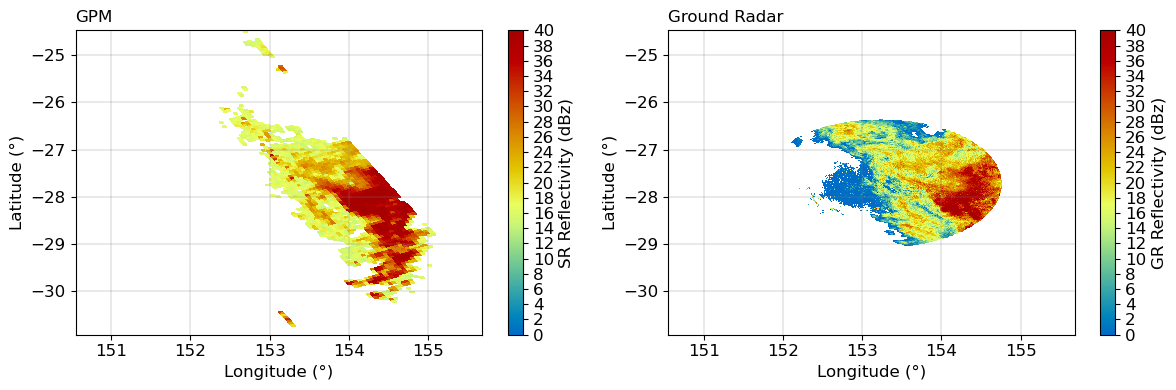

In [15]:
if platf == "trmm":
    level = 75
else:
    level = 171
plot_unmatched_refl(sr_data, swp, level=level)

### Georeference SR data

add radar AEQD coords to the SR Dataset

#### Set fundamental georeferencing parameters

In [16]:
# Todo: only keep one method

# Calculate equivalent earth radius
wgs84 = wrl.georef.get_default_projection()
# lon0_gr = gr_data.latitude.values
re1 = gr_data.ds.wrl.georef.get_earth_radius(sr=wgs84)
print("Earth radius 1:", re1)
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()
print("SemiMajor, SemiMinor:", a, b)

# Set up aeqd-projection gr-centered
rad = wrl.georef.projstr_to_osr(
    ("+proj=aeqd +lon_0={lon:f} " + "+lat_0={lat:f} +a={a:f} " + "+b={b:f}").format(
        lon=gr_data.ds.longitude.values, lat=gr_data.ds.latitude.values, a=a, b=b
    )
)
re2 = gr_data.ds.wrl.georef.get_earth_radius(sr=rad)
print("Earth radius 2:", re2)

Earth radius 1: 6373541.039814419
SemiMajor, SemiMinor: 6378137.0 6356752.314245179
Earth radius 2: 6373541.039814381


In [17]:
# todo: use dpr altitude instead fix valued zt

In [18]:
sr_data = sr_data.wrl.georef.reproject(
    coords=dict(x="Longitude", y="Latitude"), src_crs=wgs84, trg_crs=rad
)
sr_data

/tmp/ipykernel_4480/337899289.py:1: UserWarning: `src_crs`-kwarg is overriding `crs_wkt`-coordinate'
  sr_data = sr_data.wrl.georef.reproject(


<xarray.Dataset> Size: 50MB
Dimensions:                      (nswath: 1, nscan: 136, nray: 49, XYZ: 3,
                                  nbin: 176, nNP: 4, method: 6, foreBack: 2,
                                  nearFar: 2, nNode: 5, nbinSZP: 7, nDSD: 2,
                                  nNUBF: 3, LS: 2)
Coordinates:
    Latitude                     (nscan, nray) float32 27kB ...
    Longitude                    (nscan, nray) float32 27kB ...
    date                         (nscan) datetime64[ns] 1kB 2014-12-06T09:50:...
    x                            (nscan, nray) float64 53kB -2.706e+05 ... 2....
    y                            (nscan, nray) float64 53kB 2.446e+05 ... -2....
    crs_wkt                      int64 8B 0
Dimensions without coordinates: nswath, nscan, nray, XYZ, nbin, nNP, method,
                                foreBack, nearFar, nNode, nbinSZP, nDSD, nNUBF,
                                LS
Data variables: (12/96)
    AlgorithmRuntimeInfo         (nswath) |S929 929B ...
    dataQuality                  (nscan) float32 544B ...
    dataWarning                  (nscan) float32 544B ...
    missing                      (nscan) float32 544B ...
    modeStatus                   (nscan) float32 544B ...
    geoError                     (nscan) float32 544B ...
    ...                           ...
    phaseNearSurface             (nscan, nray) float32 27kB ...
    epsilon                      (nscan, nray, nbin) float32 5MB ...
    flagEcho                     (nscan, nray, nbin) float32 5MB ...
    qualityData                  (nscan, nray) float64 53kB ...
    qualityFlag                  (nscan, nray) float32 27kB ...
    flagSensor                   (nscan) float32 544B ...
Attributes:
    FileHeader:        DOI=10.5067/GPM/DPR/Ku/2A/05;\nDOIauthority=http://dx....
    InputRecord:       InputFileNames=GPMCOR_KUR_1412060833_1006_004383_1BS_D...
    NavigationRecord:  LongitudeOnEquator=-27.312063;\nUTCDateTimeOnEquator=2...
    FileInfo:          DataFormatVersion=cn;\nTKCodeBuildVersion=1;\nMetadata...
    JAXAInfo:          GranuleFirstScanUTCDateTime=2014-12-06T08:33:33.292Z;\...
    platform:          GPM

### Subset relevant SR data

Calculate distance of each SR bin to the ground radar location and select only locations within the GR range.

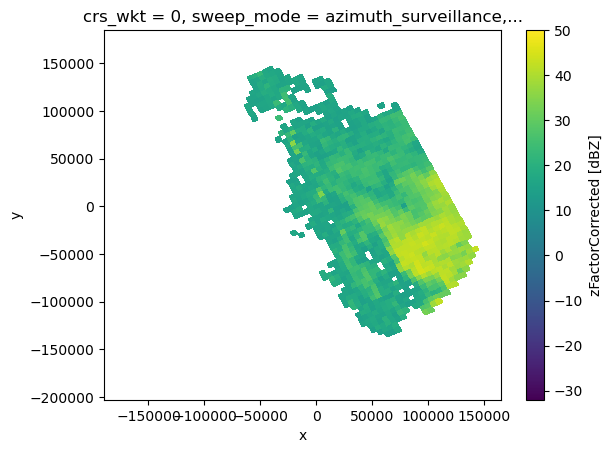

In [19]:
# calculate range and mask srdata
r = np.sqrt(sr_data.x**2 + sr_data.y**2)
sr_cut = sr_data.where(r < swp.gr.max(), drop=True)
sr_cut.zFactorCorrected[..., level].plot(x="x", y="y", vmin=-32, vmax=50)

### Subset relevant SR data with precip flag

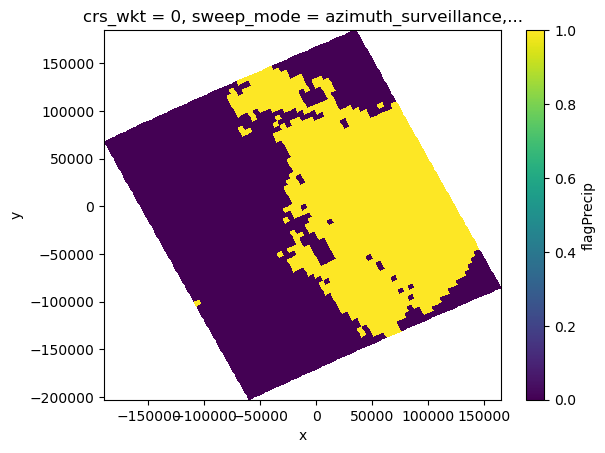

In [20]:
precip_mask = xr.where(sr_cut.flagPrecip > 0, 1, 0)
precip_mask.plot(x="x", y="y")

### SR Parallax Correction

Correct for parallax, get 3D-XYZ-Array

In [21]:
# dr_sr = 125.
# todo: make this available from wradlib
sr_cut = sr_cut.wrl.georef.correct_parallax(dr_sr)
display(sr_cut)

/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/wradlib/georef/satellite.py:124: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nbin = obj.dims["nbin"]


<xarray.Dataset> Size: 35MB
Dimensions:                      (nswath: 1, nscan: 61, nray: 49, XYZ: 3,
                                  nbin: 176, nNP: 4, method: 6, foreBack: 2,
                                  nearFar: 2, nNode: 5, nbinSZP: 7, nDSD: 2,
                                  nNUBF: 3, LS: 2)
Coordinates: (12/14)
    Latitude                     (nscan, nray) float32 12kB -27.1 ... -28.47
    Longitude                    (nscan, nray) float32 12kB 151.4 ... 154.9
    date                         (nscan) datetime64[ns] 488B 2014-12-06T09:50...
    x                            (nscan, nray) float64 24kB -1.861e+05 ... 1....
    y                            (nscan, nray) float64 24kB 6.695e+04 ... -8....
    crs_wkt                      int64 8B 0
    ...                           ...
    latitude                     float64 8B -27.72
    altitude                     float64 8B 175.0
    xp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    yp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    zp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_range                     (nbin) float64 1kB 2.188e+04 2.175e+04 ... 0.0
Dimensions without coordinates: nswath, nscan, nray, XYZ, nbin, nNP, method,
                                foreBack, nearFar, nNode, nbinSZP, nDSD, nNUBF,
                                LS
Data variables: (12/96)
    AlgorithmRuntimeInfo         (nswath, nscan, nray) object 24kB nan ... nan
    dataQuality                  (nscan, nray) float32 12kB nan nan ... nan nan
    dataWarning                  (nscan, nray) float32 12kB nan nan ... nan nan
    missing                      (nscan, nray) float32 12kB nan nan ... nan nan
    modeStatus                   (nscan, nray) float32 12kB nan nan ... nan nan
    geoError                     (nscan, nray) float32 12kB nan nan ... nan nan
    ...                           ...
    phaseNearSurface             (nscan, nray) float32 12kB nan nan ... nan nan
    epsilon                      (nscan, nray, nbin) float32 2MB nan nan ... nan
    flagEcho                     (nscan, nray, nbin) float32 2MB nan nan ... nan
    qualityData                  (nscan, nray) float64 24kB nan nan ... nan nan
    qualityFlag                  (nscan, nray) float32 12kB nan nan ... nan nan
    flagSensor                   (nscan, nray) float32 12kB nan nan ... nan nan
Attributes:
    FileHeader:        DOI=10.5067/GPM/DPR/Ku/2A/05;\nDOIauthority=http://dx....
    InputRecord:       InputFileNames=GPMCOR_KUR_1412060833_1006_004383_1BS_D...
    NavigationRecord:  LongitudeOnEquator=-27.312063;\nUTCDateTimeOnEquator=2...
    FileInfo:          DataFormatVersion=cn;\nTKCodeBuildVersion=1;\nMetadata...
    JAXAInfo:          GranuleFirstScanUTCDateTime=2014-12-06T08:33:33.292Z;\...
    platform:          GPM

### Compute spherical coordinates of SR bins with regard to GR

range, azimuth, elevation

In [22]:
sr_cut = sr_cut.wrl.georef.xyz_to_spherical(crs=rad)
sr_cut

<xarray.Dataset> Size: 48MB
Dimensions:                      (nswath: 1, nscan: 61, nray: 49, XYZ: 3,
                                  nbin: 176, nNP: 4, method: 6, foreBack: 2,
                                  nearFar: 2, nNode: 5, nbinSZP: 7, nDSD: 2,
                                  nNUBF: 3, LS: 2)
Coordinates: (12/17)
    elevation                    (nscan, nray, nbin) float64 4MB nan nan ... nan
    Latitude                     (nscan, nray) float32 12kB -27.1 ... -28.47
    Longitude                    (nscan, nray) float32 12kB 151.4 ... 154.9
    date                         (nscan) datetime64[ns] 488B 2014-12-06T09:50...
    x                            (nscan, nray) float64 24kB -1.861e+05 ... 1....
    y                            (nscan, nray) float64 24kB 6.695e+04 ... -8....
    ...                           ...
    xp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    yp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    zp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_range                     (nbin) float64 1kB 2.188e+04 2.175e+04 ... 0.0
    range                        (nscan, nray, nbin) float64 4MB nan nan ... nan
    azimuth                      (nscan, nray, nbin) float64 4MB nan nan ... nan
Dimensions without coordinates: nswath, nscan, nray, XYZ, nbin, nNP, method,
                                foreBack, nearFar, nNode, nbinSZP, nDSD, nNUBF,
                                LS
Data variables: (12/95)
    AlgorithmRuntimeInfo         (nswath, nscan, nray) object 24kB nan ... nan
    dataQuality                  (nscan, nray) float32 12kB nan nan ... nan nan
    dataWarning                  (nscan, nray) float32 12kB nan nan ... nan nan
    missing                      (nscan, nray) float32 12kB nan nan ... nan nan
    modeStatus                   (nscan, nray) float32 12kB nan nan ... nan nan
    geoError                     (nscan, nray) float32 12kB nan nan ... nan nan
    ...                           ...
    phaseNearSurface             (nscan, nray) float32 12kB nan nan ... nan nan
    epsilon                      (nscan, nray, nbin) float32 2MB nan nan ... nan
    flagEcho                     (nscan, nray, nbin) float32 2MB nan nan ... nan
    qualityData                  (nscan, nray) float64 24kB nan nan ... nan nan
    qualityFlag                  (nscan, nray) float32 12kB nan nan ... nan nan
    flagSensor                   (nscan, nray) float32 12kB nan nan ... nan nan
Attributes:
    FileHeader:        DOI=10.5067/GPM/DPR/Ku/2A/05;\nDOIauthority=http://dx....
    InputRecord:       InputFileNames=GPMCOR_KUR_1412060833_1006_004383_1BS_D...
    NavigationRecord:  LongitudeOnEquator=-27.312063;\nUTCDateTimeOnEquator=2...
    FileInfo:          DataFormatVersion=cn;\nTKCodeBuildVersion=1;\nMetadata...
    JAXAInfo:          GranuleFirstScanUTCDateTime=2014-12-06T08:33:33.292Z;\...
    platform:          GPM

## Compute SR and GR pulse volumes

### Calculate distance from orbit $r_s$

In [23]:
bw_sr = 0.71
freq = 0
sr_cut = sr_cut.wrl.georef.dist_from_orbit(bw_sr, freq, re1)
sr_cut

/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/wradlib/georef/satellite.py:226: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nray_sr = obj.dims["nray"]


<xarray.Dataset> Size: 52MB
Dimensions:                      (nswath: 1, nscan: 61, nray: 49, XYZ: 3,
                                  nbin: 176, nNP: 4, method: 6, foreBack: 2,
                                  nearFar: 2, nNode: 5, nbinSZP: 7, nDSD: 2,
                                  nNUBF: 3, LS: 2)
Coordinates: (12/18)
    elevation                    (nscan, nray, nbin) float64 4MB nan nan ... nan
    Latitude                     (nscan, nray) float32 12kB -27.1 ... -28.47
    Longitude                    (nscan, nray) float32 12kB 151.4 ... 154.9
    date                         (nscan) datetime64[ns] 488B 2014-12-06T09:50...
    x                            (nscan, nray) float64 24kB -1.861e+05 ... 1....
    y                            (nscan, nray) float64 24kB 6.695e+04 ... -8....
    ...                           ...
    yp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    zp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_range                     (nbin) float64 1kB 2.188e+04 2.175e+04 ... 0.0
    range                        (nscan, nray, nbin) float64 4MB nan nan ... nan
    azimuth                      (nscan, nray, nbin) float64 4MB nan nan ... nan
    pr_dist                      (nscan, nray, nbin) float64 4MB nan nan ... nan
Dimensions without coordinates: nswath, nscan, nray, XYZ, nbin, nNP, method,
                                foreBack, nearFar, nNode, nbinSZP, nDSD, nNUBF,
                                LS
Data variables: (12/95)
    AlgorithmRuntimeInfo         (nswath, nscan, nray) object 24kB nan ... nan
    dataQuality                  (nscan, nray) float32 12kB nan nan ... nan nan
    dataWarning                  (nscan, nray) float32 12kB nan nan ... nan nan
    missing                      (nscan, nray) float32 12kB nan nan ... nan nan
    modeStatus                   (nscan, nray) float32 12kB nan nan ... nan nan
    geoError                     (nscan, nray) float32 12kB nan nan ... nan nan
    ...                           ...
    phaseNearSurface             (nscan, nray) float32 12kB nan nan ... nan nan
    epsilon                      (nscan, nray, nbin) float32 2MB nan nan ... nan
    flagEcho                     (nscan, nray, nbin) float32 2MB nan nan ... nan
    qualityData                  (nscan, nray) float64 24kB nan nan ... nan nan
    qualityFlag                  (nscan, nray) float32 12kB nan nan ... nan nan
    flagSensor                   (nscan, nray) float32 12kB nan nan ... nan nan
Attributes:
    FileHeader:        DOI=10.5067/GPM/DPR/Ku/2A/05;\nDOIauthority=http://dx....
    InputRecord:       InputFileNames=GPMCOR_KUR_1412060833_1006_004383_1BS_D...
    NavigationRecord:  LongitudeOnEquator=-27.312063;\nUTCDateTimeOnEquator=2...
    FileInfo:          DataFormatVersion=cn;\nTKCodeBuildVersion=1;\nMetadata...
    JAXAInfo:          GranuleFirstScanUTCDateTime=2014-12-06T08:33:33.292Z;\...
    platform:          GPM

#### SR pulse volume

Todo: only keep pulse_volume method

In [24]:
# # Small angle approximation
rs = sr_cut["pr_dist"]

# vol_sr2 = np.pi * dr_sr * rs**2 * np.radians(bw_sr / 2.0) ** 2

# Or using wradlib's native function
vol_sr = rs.wrl.qual.pulse_volume(dr_sr, bw_sr)
sr_cut = sr_cut.assign(vol_sr=vol_sr)
# # Evaluate difference between both approaches
# print("Min. difference (m3):", vol_sr.max(), (vol_sr - vol_sr2).min())
# print("Max. difference (m3): ", vol_sr2.max(), (vol_sr - vol_sr2).max())
# print(
#     "Average rel. difference (%):",
#     np.round(np.mean(vol_sr - vol_sr2) * 100.0 / np.mean(np.mean(vol_sr2)), 4),
# )

# Verdict: differences are negligble - use wradlibs's native function!

#### GR pulse volume

In [25]:
# GR pulse volumes
#   along one beam
# todo: check beam width
bw_gr = 1.0
vol_gr = wrl.qual.pulse_volume(swp.range, swp.range.diff("range").median(), bw_gr)
vol_gr = vol_gr.broadcast_like(swp.DBZH)
display(vol_gr)
#   with shape (nray_gr, ngate_gr)
# vol_gr = np.repeat(vol_gr, nray_gr).reshape((nray_gr, ngate_gr), order="F")

<xarray.DataArray 'range' (azimuth: 360, range: 600)> Size: 2MB
array([[9.34601988e+02, 8.41141789e+03, 2.33650497e+04, ...,
        1.33463499e+09, 1.33910612e+09, 1.34358473e+09],
       [9.34601988e+02, 8.41141789e+03, 2.33650497e+04, ...,
        1.33463499e+09, 1.33910612e+09, 1.34358473e+09],
       [9.34601988e+02, 8.41141789e+03, 2.33650497e+04, ...,
        1.33463499e+09, 1.33910612e+09, 1.34358473e+09],
       ...,
       [9.34601988e+02, 8.41141789e+03, 2.33650497e+04, ...,
        1.33463499e+09, 1.33910612e+09, 1.34358473e+09],
       [9.34601988e+02, 8.41141789e+03, 2.33650497e+04, ...,
        1.33463499e+09, 1.33910612e+09, 1.34358473e+09],
       [9.34601988e+02, 8.41141789e+03, 2.33650497e+04, ...,
        1.33463499e+09, 1.33910612e+09, 1.34358473e+09]], shape=(360, 600))
Coordinates:
    sweep_mode  <U20 80B 'azimuth_surveillance'
    longitude   float64 8B 153.2
    latitude    float64 8B -27.72
    altitude    float64 8B 175.0
    crs_wkt     int64 8B 0
  * range       (range) float32 2kB 125.0 375.0 625.0 ... 1.496e+05 1.499e+05
  * azimuth     (azimuth) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5

#### Calculate horizontal and vertical dimensions $R_s$ and $D_s$ of SR bins

Select freq=0 for Ku-Band.

In [26]:
freq = 0
alpha = sr_cut["localZenithAngle"].isel(nfreq=freq, missing_dims="ignore")

# Rs
sr_bin_radius = (
    0.5 * (1 + np.cos(np.radians(alpha))) * rs * np.tan(np.radians(bw_sr / 2.0))
)
sr_bin_radius.name = "sr_bin_radius"

# Ds
sr_bin_depth = dr_sr / np.cos(np.radians(alpha))
sr_bin_depth.name = "sr_bin_depth"

<xarray.Dataset> Size: 61MB
Dimensions:                      (nswath: 1, nscan: 61, nray: 49, XYZ: 3,
                                  nbin: 176, nNP: 4, method: 6, foreBack: 2,
                                  nearFar: 2, nNode: 5, nbinSZP: 7, nDSD: 2,
                                  nNUBF: 3, LS: 2)
Coordinates: (12/18)
    elevation                    (nscan, nray, nbin) float64 4MB nan nan ... nan
    Latitude                     (nscan, nray) float32 12kB -27.1 ... -28.47
    Longitude                    (nscan, nray) float32 12kB 151.4 ... 154.9
    date                         (nscan) datetime64[ns] 488B 2014-12-06T09:50...
    x                            (nscan, nray) float64 24kB -1.861e+05 ... 1....
    y                            (nscan, nray) float64 24kB 6.695e+04 ... -8....
    ...                           ...
    yp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    zp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_range                     (nbin) float64 1kB 2.188e+04 2.175e+04 ... 0.0
    range                        (nscan, nray, nbin) float64 4MB nan nan ... nan
    azimuth                      (nscan, nray, nbin) float64 4MB nan nan ... nan
    pr_dist                      (nscan, nray, nbin) float64 4MB nan nan ... nan
Dimensions without coordinates: nswath, nscan, nray, XYZ, nbin, nNP, method,
                                foreBack, nearFar, nNode, nbinSZP, nDSD, nNUBF,
                                LS
Data variables: (12/98)
    AlgorithmRuntimeInfo         (nswath, nscan, nray) object 24kB nan ... nan
    dataQuality                  (nscan, nray) float32 12kB nan nan ... nan nan
    dataWarning                  (nscan, nray) float32 12kB nan nan ... nan nan
    missing                      (nscan, nray) float32 12kB nan nan ... nan nan
    modeStatus                   (nscan, nray) float32 12kB nan nan ... nan nan
    geoError                     (nscan, nray) float32 12kB nan nan ... nan nan
    ...                           ...
    qualityData                  (nscan, nray) float64 24kB nan nan ... nan nan
    qualityFlag                  (nscan, nray) float32 12kB nan nan ... nan nan
    flagSensor                   (nscan, nray) float32 12kB nan nan ... nan nan
    vol_sr                       (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_bin_radius                (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_bin_depth                 (nscan, nray) float32 12kB nan nan ... nan nan
Attributes:
    FileHeader:        DOI=10.5067/GPM/DPR/Ku/2A/05;\nDOIauthority=http://dx....
    InputRecord:       InputFileNames=GPMCOR_KUR_1412060833_1006_004383_1BS_D...
    NavigationRecord:  LongitudeOnEquator=-27.312063;\nUTCDateTimeOnEquator=2...
    FileInfo:          DataFormatVersion=cn;\nTKCodeBuildVersion=1;\nMetadata...
    JAXAInfo:          GranuleFirstScanUTCDateTime=2014-12-06T08:33:33.292Z;\...
    platform:          GPM

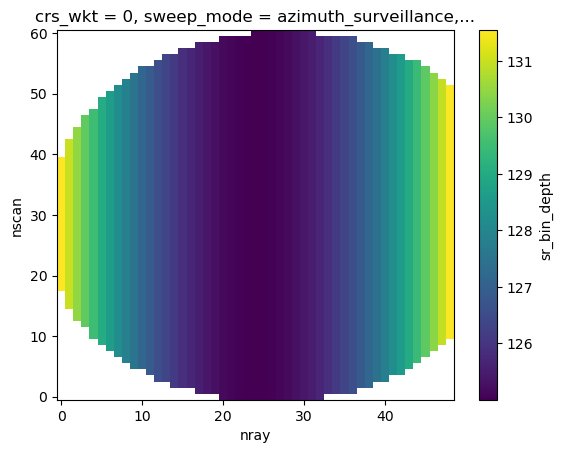

In [27]:
sr_cut = sr_cut.assign(sr_bin_radius=sr_bin_radius, sr_bin_depth=sr_bin_depth)
display(sr_cut)
sr_cut.sr_bin_depth.plot()

## BrightBand Handling

### Median Brightband Width/Height

In [28]:
# if platf == "gpm":
sr_cut = sr_cut.wrl.qual.get_bb_ratio()
display(sr_cut)

<xarray.Dataset> Size: 65MB
Dimensions:                      (nswath: 1, nscan: 61, nray: 49, XYZ: 3,
                                  nbin: 176, nNP: 4, method: 6, foreBack: 2,
                                  nearFar: 2, nNode: 5, nbinSZP: 7, nDSD: 2,
                                  nNUBF: 3, LS: 2)
Coordinates: (12/18)
    elevation                    (nscan, nray, nbin) float64 4MB nan nan ... nan
    Latitude                     (nscan, nray) float32 12kB -27.1 ... -28.47
    Longitude                    (nscan, nray) float32 12kB 151.4 ... 154.9
    date                         (nscan) datetime64[ns] 488B 2014-12-06T09:50...
    x                            (nscan, nray) float64 24kB -1.861e+05 ... 1....
    y                            (nscan, nray) float64 24kB 6.695e+04 ... -8....
    ...                           ...
    yp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    zp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_range                     (nbin) float64 1kB 2.188e+04 2.175e+04 ... 0.0
    range                        (nscan, nray, nbin) float64 4MB nan nan ... nan
    azimuth                      (nscan, nray, nbin) float64 4MB nan nan ... nan
    pr_dist                      (nscan, nray, nbin) float64 4MB nan nan ... nan
Dimensions without coordinates: nswath, nscan, nray, XYZ, nbin, nNP, method,
                                foreBack, nearFar, nNode, nbinSZP, nDSD, nNUBF,
                                LS
Data variables: (12/100)
    AlgorithmRuntimeInfo         (nswath, nscan, nray) object 24kB nan ... nan
    dataQuality                  (nscan, nray) float32 12kB nan nan ... nan nan
    dataWarning                  (nscan, nray) float32 12kB nan nan ... nan nan
    missing                      (nscan, nray) float32 12kB nan nan ... nan nan
    modeStatus                   (nscan, nray) float32 12kB nan nan ... nan nan
    geoError                     (nscan, nray) float32 12kB nan nan ... nan nan
    ...                           ...
    flagSensor                   (nscan, nray) float32 12kB nan nan ... nan nan
    vol_sr                       (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_bin_radius                (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_bin_depth                 (nscan, nray) float32 12kB nan nan ... nan nan
    bb_ratio                     (nscan, nray, nbin) float64 4MB nan nan ... nan
    bb_mask                      (nscan, nray) bool 3kB False False ... False
Attributes:
    FileHeader:        DOI=10.5067/GPM/DPR/Ku/2A/05;\nDOIauthority=http://dx....
    InputRecord:       InputFileNames=GPMCOR_KUR_1412060833_1006_004383_1BS_D...
    NavigationRecord:  LongitudeOnEquator=-27.312063;\nUTCDateTimeOnEquator=2...
    FileInfo:          DataFormatVersion=cn;\nTKCodeBuildVersion=1;\nMetadata...
    JAXAInfo:          GranuleFirstScanUTCDateTime=2014-12-06T08:33:33.292Z;\...
    platform:          GPM

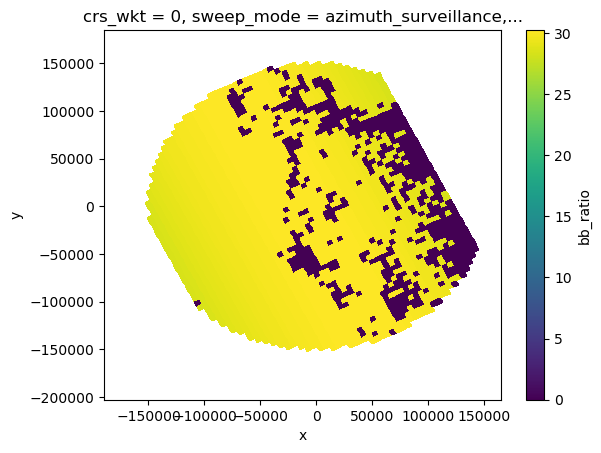

In [29]:
sr_cut["bb_ratio"].isel(nbin=0).plot(x="x", y="y")

### Convert SR Ku reflectivities to S-band 

Based on [Cao et.al (2013)](https://doi.org/10.1002/jgrd.50138)

In [30]:
ref_sr = sr_cut.zFactorCorrected.isel(nfreq=0, missing_dims="ignore").copy()
# ref_sr = sr_data['refl'].filled(np.nan)
ref_sr_ss = xr.zeros_like(ref_sr) * np.nan
ref_sr_sh = xr.zeros_like(ref_sr) * np.nan

a_s, a_h = (wrl.trafo.KuBandToS.snow, wrl.trafo.KuBandToS.hail)

In [31]:
# mask bb_ratio with bb_mask
ratio = sr_cut["bb_ratio"].where(sr_cut["bb_mask"])
ia = ratio >= 1
ib = ratio <= 0
im = (ratio > 0) & (ratio < 1)
ind = xr.where(im, np.round(ratio * 10), 0).astype("int")
# print(ind)
# ind = np.round(ratio[im] * 10).astype(np.int)

# ref_sr_ss = ref_sr.copy()
# ref_sr_sh = ref_sr.copy()

In [32]:
ia

<xarray.DataArray 'bb_ratio' (nscan: 61, nray: 49, nbin: 176)> Size: 526kB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]],
      shape=(61, 49, 176))
Coordinates: (12/18)
    elevation   (nscan, nray, nbin) float64 4MB nan nan nan nan ... nan nan nan
    Latitude    (nscan, nray) float32 12kB -27.1 -27.08 -27.06 ... -28.49 -28.47
    Longitude   (nscan, nray) float32 12kB 151.4 151.4 151.5 ... 154.8 154.9
    date        (nscan) datetime64[ns] 488B 2014-12-06T09:50:30.000500 ... 20...
    x           (nscan, nray) float64 24kB -1.861e+05 -1.813e+05 ... 1.613e+05
    y           (nscan, nray) float64 24kB 6.695e+04 6.958e+04 ... -8.461e+04
    ...          ...
    yp          (nscan, nray, nbin) float64 4MB nan nan nan nan ... nan nan nan
    zp          (nscan, nray, nbin) float64 4MB nan nan nan nan ... nan nan nan
    sr_range    (nbin) float64 1kB 2.188e+04 2.175e+04 2.162e+04 ... 125.0 0.0
    range       (nscan, nray, nbin) float64 4MB nan nan nan nan ... nan nan nan
    azimuth     (nscan, nray, nbin) float64 4MB nan nan nan nan ... nan nan nan
    pr_dist     (nscan, nray, nbin) float64 4MB nan nan nan nan ... nan nan nan
Dimensions without coordinates: nscan, nray, nbin

3625.0


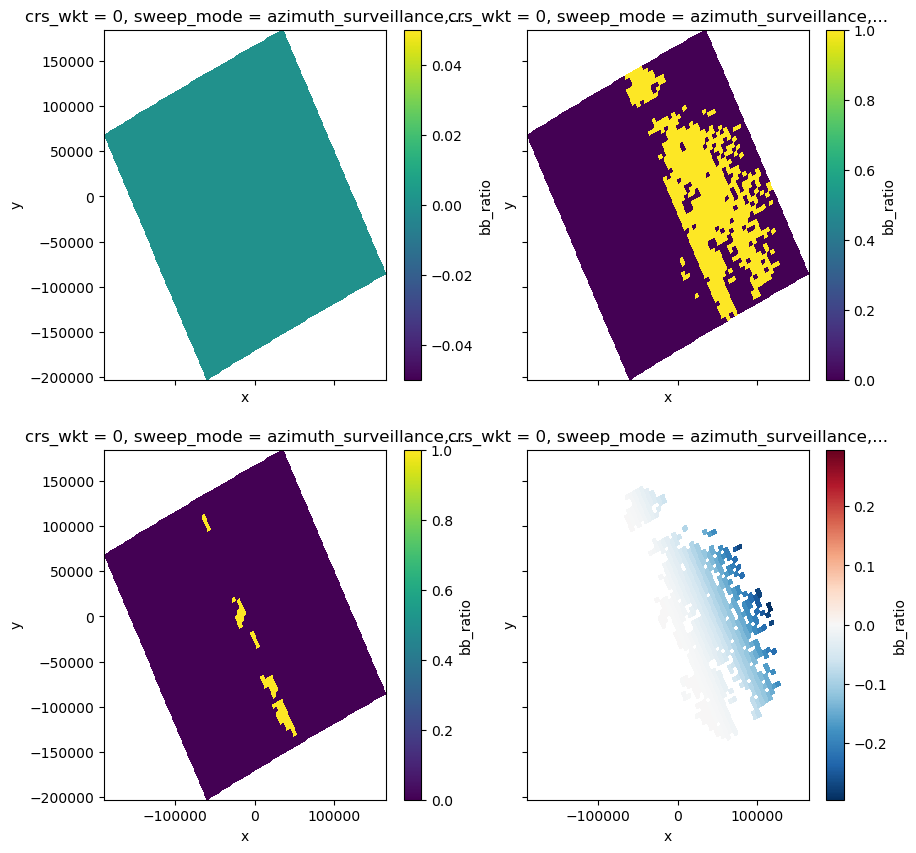

In [33]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, ncols=2, figsize=(10, 10), sharey=True, sharex=True
)
hind = 146
print(sr_cut.isel(nbin=hind).sr_range.values)
ia.isel(nbin=hind).plot(x="x", y="y", ax=ax1)
ib.isel(nbin=hind).plot(x="x", y="y", ax=ax2)
im.isel(nbin=hind).plot(x="x", y="y", ax=ax3)
ratio.isel(nbin=hind).plot(x="x", y="y", ax=ax4)
# sr_cut["bb_mask"].plot(x="x", y="y", ax=ax4)

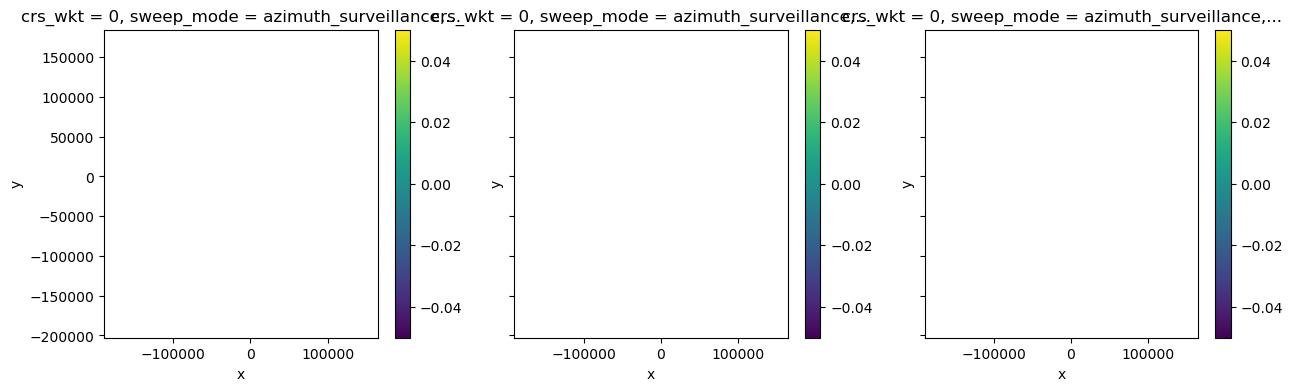

In [34]:
# adding ia/ib/im in sequential order to ref_sr_ss/ref_sr/sh

# above melting layer -> no mixing only snow/hail
ref_sr_ss = xr.where(
    ia, ref_sr + wrl.util.calculate_polynomial(ref_sr.copy(), a_s[:, 10]), ref_sr_ss
)
ref_sr_sh = xr.where(
    ia, ref_sr + wrl.util.calculate_polynomial(ref_sr.copy(), a_h[:, 10]), ref_sr_sh
)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)
ref_sr_ss.isel(nbin=hind).plot(x="x", y="y", ax=ax1)
ref_sr_sh.isel(nbin=hind).plot(x="x", y="y", ax=ax2)
(ref_sr_ss - ref_sr_sh).isel(nbin=hind).plot(x="x", y="y", ax=ax3)

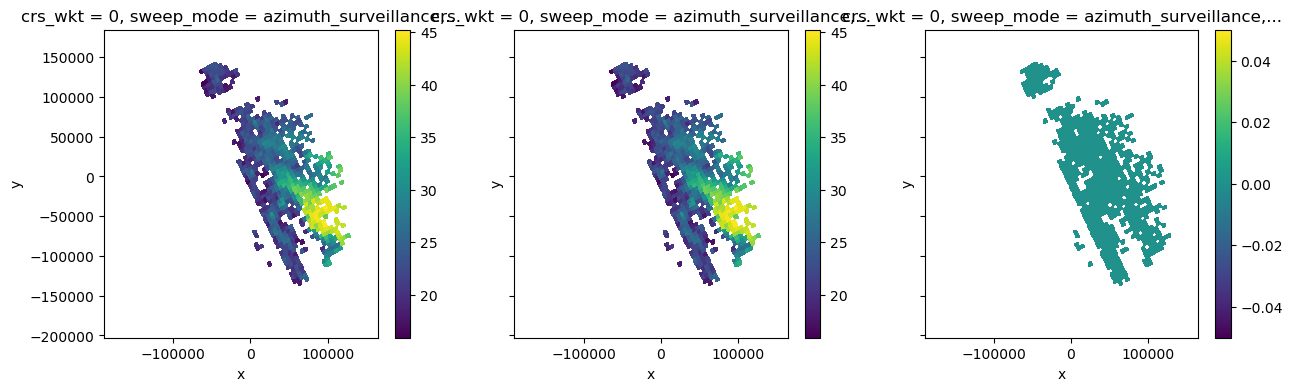

In [35]:
# below the melting layer
ref_sr_ss = xr.where(
    ib, ref_sr + wrl.util.calculate_polynomial(ref_sr.copy(), a_s[:, 0]), ref_sr_ss
)
ref_sr_sh = xr.where(
    ib, ref_sr + wrl.util.calculate_polynomial(ref_sr.copy(), a_h[:, 0]), ref_sr_sh
)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)
ref_sr_ss.isel(nbin=hind).plot(x="x", y="y", ax=ax1)
ref_sr_sh.isel(nbin=hind).plot(x="x", y="y", ax=ax2)
(ref_sr_ss - ref_sr_sh).isel(nbin=hind).plot(x="x", y="y", ax=ax3)

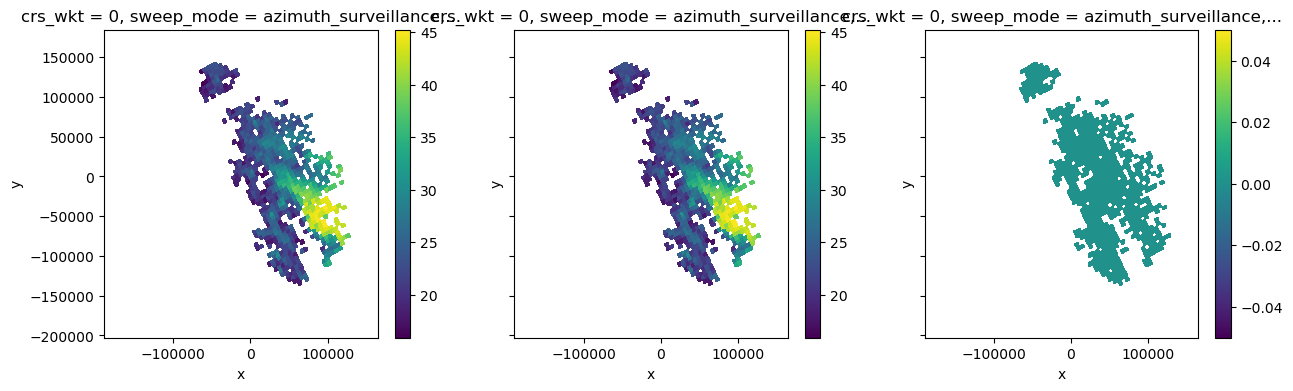

In [36]:
# inside melting layer
ref_sr_ss = xr.where(
    im, ref_sr + wrl.util.calculate_polynomial(ref_sr.copy(), a_s[:, ind]), ref_sr_ss
)
ref_sr_sh = xr.where(
    im, ref_sr + wrl.util.calculate_polynomial(ref_sr.copy(), a_h[:, ind]), ref_sr_sh
)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)
ref_sr_ss.isel(nbin=hind).plot(x="x", y="y", ax=ax1)
ref_sr_sh.isel(nbin=hind).plot(x="x", y="y", ax=ax2)
(ref_sr_ss - ref_sr_sh).isel(nbin=hind).plot(x="x", y="y", ax=ax3)

In [37]:
# Jackson Tan's fix for C-band
# if gr_radar_band == 'C':
#     print('SR reflectivity is converted to C-band')
#     deltas = (ref_sr_ss - ref_sr) * 5.3 / 10.0
#     ref_sr_ss = ref_sr + deltas
#     deltah = (ref_sr_sh - ref_sr) * 5.3 / 10.0
#     ref_sr_sh = ref_sr + deltah
# gr_radar_band = "S"
# if gr_radar_band == 'X':
#     print('SR reflectivity is converted to X-band')
#     deltas = (ref_sr_ss - ref_sr) * 3.2 / 10.0
#     ref_sr_ss = ref_sr + deltas
#     deltah = (ref_sr_sh - ref_sr) * 3.2 / 10.0
#     ref_sr_sh = ref_sr + deltah

# ref_sr_ss = ref_sr_ss.where(ref_sr >= 0)
# ref_sr_sh = ref_sr_sh.where(ref_sr >= 0)

/home/runner/micromamba/envs/wradlib-tests/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


<xarray.DataArray 'typePrecip' (nscan: 61, nray: 49)> Size: 6kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(61, 49), dtype=int16)
Coordinates:
    Latitude    (nscan, nray) float32 12kB -27.1 -27.08 -27.06 ... -28.49 -28.47
    Longitude   (nscan, nray) float32 12kB 151.4 151.4 151.5 ... 154.8 154.9
    date        (nscan) datetime64[ns] 488B 2014-12-06T09:50:30.000500 ... 20...
    x           (nscan, nray) float64 24kB -1.861e+05 -1.813e+05 ... 1.613e+05
    y           (nscan, nray) float64 24kB 6.695e+04 6.958e+04 ... -8.461e+04
    crs_wkt     int64 8B 0
    sweep_mode  <U20 80B 'azimuth_surveillance'
    longitude   float64 8B 153.2
    latitude    float64 8B -27.72
    altitude    float64 8B 175.0
Dimensions without coordinates: nscan, nray

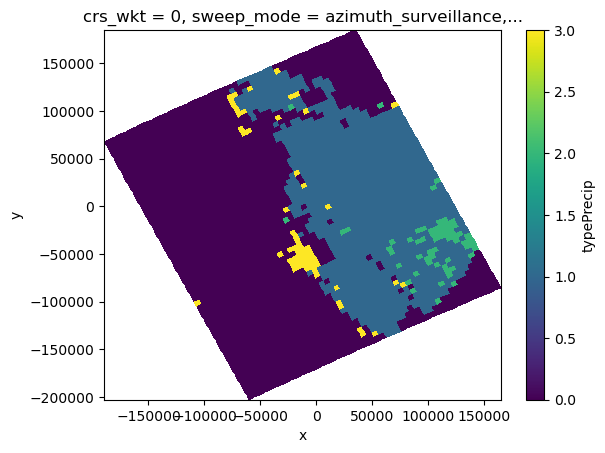

In [38]:
if platf == "gpm":
    ptype = (sr_cut.typePrecip / 1e7).astype(np.int16)
else:
    ptype = sr_cut.typePrecip
display(ptype)
ptype.plot(x="x", y="y")

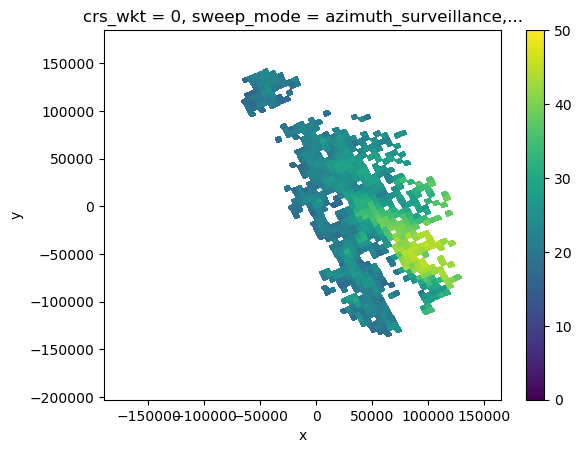

In [39]:
# Combined conversion
ref_sr_com = xr.zeros_like(ref_sr_ss) * np.nan
ref_sr_com = xr.where(ptype == 1, ref_sr_ss, ref_sr_com)
ref_sr_com = xr.where(ptype == 2, ref_sr_sh, ref_sr_com)
ref_sr_com.isel(nbin=hind).plot(x="x", y="y", vmin=0, vmax=50)

In [40]:
sr_cut = sr_cut.assign(ref_sr_com=ref_sr_com, ref_sr_ss=ref_sr_ss, ref_sr_sh=ref_sr_sh)
display(sr_cut)

<xarray.Dataset> Size: 71MB
Dimensions:                      (nswath: 1, nscan: 61, nray: 49, XYZ: 3,
                                  nbin: 176, nNP: 4, method: 6, foreBack: 2,
                                  nearFar: 2, nNode: 5, nbinSZP: 7, nDSD: 2,
                                  nNUBF: 3, LS: 2)
Coordinates: (12/18)
    elevation                    (nscan, nray, nbin) float64 4MB nan nan ... nan
    Latitude                     (nscan, nray) float32 12kB -27.1 ... -28.47
    Longitude                    (nscan, nray) float32 12kB 151.4 ... 154.9
    date                         (nscan) datetime64[ns] 488B 2014-12-06T09:50...
    x                            (nscan, nray) float64 24kB -1.861e+05 ... 1....
    y                            (nscan, nray) float64 24kB 6.695e+04 ... -8....
    ...                           ...
    yp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    zp                           (nscan, nray, nbin) float64 4MB nan nan ... nan
    sr_range                     (nbin) float64 1kB 2.188e+04 2.175e+04 ... 0.0
    range                        (nscan, nray, nbin) float64 4MB nan nan ... nan
    azimuth                      (nscan, nray, nbin) float64 4MB nan nan ... nan
    pr_dist                      (nscan, nray, nbin) float64 4MB nan nan ... nan
Dimensions without coordinates: nswath, nscan, nray, XYZ, nbin, nNP, method,
                                foreBack, nearFar, nNode, nbinSZP, nDSD, nNUBF,
                                LS
Data variables: (12/103)
    AlgorithmRuntimeInfo         (nswath, nscan, nray) object 24kB nan ... nan
    dataQuality                  (nscan, nray) float32 12kB nan nan ... nan nan
    dataWarning                  (nscan, nray) float32 12kB nan nan ... nan nan
    missing                      (nscan, nray) float32 12kB nan nan ... nan nan
    modeStatus                   (nscan, nray) float32 12kB nan nan ... nan nan
    geoError                     (nscan, nray) float32 12kB nan nan ... nan nan
    ...                           ...
    sr_bin_depth                 (nscan, nray) float32 12kB nan nan ... nan nan
    bb_ratio                     (nscan, nray, nbin) float64 4MB nan nan ... nan
    bb_mask                      (nscan, nray) bool 3kB False False ... False
    ref_sr_com                   (nscan, nray, nbin) float32 2MB nan nan ... nan
    ref_sr_ss                    (nscan, nray, nbin) float32 2MB nan nan ... nan
    ref_sr_sh                    (nscan, nray, nbin) float32 2MB nan nan ... nan
Attributes:
    FileHeader:        DOI=10.5067/GPM/DPR/Ku/2A/05;\nDOIauthority=http://dx....
    InputRecord:       InputFileNames=GPMCOR_KUR_1412060833_1006_004383_1BS_D...
    NavigationRecord:  LongitudeOnEquator=-27.312063;\nUTCDateTimeOnEquator=2...
    FileInfo:          DataFormatVersion=cn;\nTKCodeBuildVersion=1;\nMetadata...
    JAXAInfo:          GranuleFirstScanUTCDateTime=2014-12-06T08:33:33.292Z;\...
    platform:          GPM

### Convert S-band GR reflectivities to Ku-band

Using the method of [Liao and Meneghini (2009)](https://doi.org/10.1175/2008JAMC1974.1)

In [41]:
ref_gr = swp["DBZH"].copy()

# Convert S-band GR reflectivities to Ku-band using method of Liao and Meneghini (2009)
ref_gr2sr = np.zeros_like(ref_gr) * np.nan

# Which zbb value should we take here???
#    Q'n'Dirty: just take the mean of all SR profiles
#    TODO: Consider zbb for each profile during the matching process

zbb = sr_cut["heightBB"]

# Snow
ia = swp.z >= np.nanmean(zbb)
ref_gr2sr = xr.where(
    ia, wrl.util.calculate_polynomial(ref_gr, wrl.trafo.SBandToKu.snow), ref_gr2sr
)
# Rain
ib = swp.z < np.nanmean(zbb)
ref_gr2sr = xr.where(
    ib, wrl.util.calculate_polynomial(ref_gr, wrl.trafo.SBandToKu.rain), ref_gr2sr
)

# # Jackson Tan's fix for C-band
# is_cband = False
# if is_cband:
#     delta = (ref_gr_ku - ref_gr) * 3.2 / 10.0
#     ref_gr_ku = ref_gr + delta

In [42]:
display(ref_gr2sr)

<xarray.DataArray (azimuth: 360, range: 600)> Size: 2MB
array([[         nan,          nan,  -9.54017664, ...,   5.206671  ,
          0.185074  ,   5.206671  ],
       [         nan,          nan,  -7.93441585, ...,   4.20992008,
          1.19696188,   4.20992008],
       [         nan,          nan,  -7.93441585, ...,   2.20506552,
          1.19696188,   2.20506552],
       ...,
       [         nan,          nan, -11.14519317, ...,   6.19963768,
          7.18882012,   8.17421832],
       [         nan,          nan, -11.14519317, ...,   7.18882012,
          6.19963768,   2.20506552],
       [         nan,          nan, -33.5372763 , ...,   6.19963768,
          4.20992008,   4.20992008]], shape=(360, 600))
Coordinates: (12/17)
    sweep_mode  <U20 80B 'azimuth_surveillance'
  * azimuth     (azimuth) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation   (azimuth) float64 3kB 1.3 1.3 1.3 1.3 1.3 ... 1.3 1.3 1.3 1.3
    time        (azimuth) datetime64[ns] 3kB 2014-12-06T09:49:31.036111104 .....
  * range       (range) float32 2kB 125.0 375.0 625.0 ... 1.496e+05 1.499e+05
    longitude   float64 8B 153.2
    ...          ...
    gr          (azimuth, range) float64 2MB 125.0 374.9 ... 1.495e+05 1.498e+05
    rays        (azimuth, range) float32 864kB 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float32 864kB 125.0 375.0 ... 1.499e+05
    crs_wkt     int64 8B 0
    lon         (azimuth, range) float64 2MB 153.2 153.2 153.2 ... 153.2 153.2
    lat         (azimuth, range) float64 2MB -27.72 -27.71 ... -26.37 -26.37

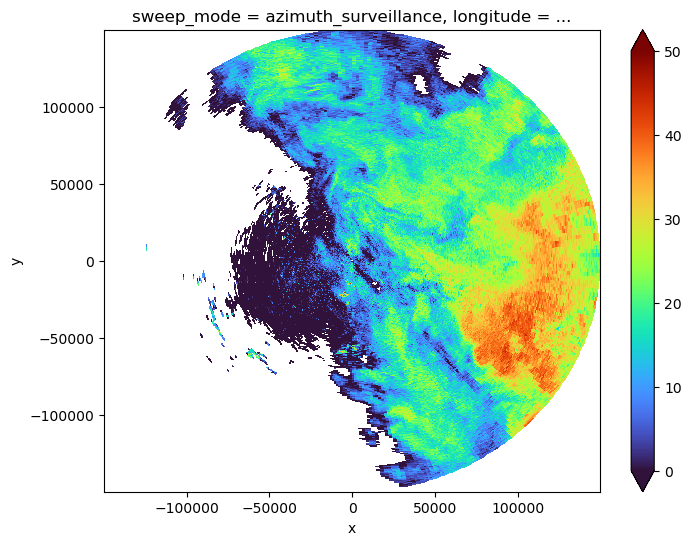

In [43]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ref_gr2sr.plot(x="x", y="y", ax=ax1, cmap="turbo", vmin=0, vmax=50)

## Matching SR/GR

### Identify which SR rays actually intersect with the GR sweep

Based on the above criteria (in radar range, precipitating SR profile) and based on SR elevation angle (with regard to GR).

This will only keep the wanted value in sr_match.

- sr_cut contains all satellite reflectivities we need. ref_sr_ss, ref_sr_sh, ref_sr_com, zFactorCorrected.

In [44]:
sr_match = sr_cut.reset_coords(["xp", "yp", "zp"])
sr_match = sr_match.where(precip_mask).where(
    (sr_match.elevation >= (swp.sweep_fixed_angle - bw_gr / 2.0))
    & (sr_match.elevation <= (swp.sweep_fixed_angle + bw_gr / 2.0))
)

In [45]:
# calculate nbeams
sr_match_mean = sr_match.mean("nbin")
xyzp_sr = xr.concat(
    [sr_match_mean.xp, sr_match_mean.yp, sr_match_mean.zp], dim="ncoord"
).transpose(..., "ncoord")
xyzp_sr = (
    xyzp_sr.stack(nbeams=("nscan", "nray"))
    .transpose("nbeams", "ncoord", ...)
    .dropna(
        dim="nbeams",
    )
)
nbeams = xyzp_sr.nbeams
nbeams

<xarray.DataArray 'nbeams' (nbeams: 1218)> Size: 10kB
[1218 values with dtype=object]
Coordinates: (12/13)
    Latitude    (nbeams) float32 5kB -26.55 -26.52 -26.5 ... -28.93 -28.9 -28.88
    Longitude   (nbeams) float32 5kB 152.6 152.6 152.6 ... 153.9 153.9 154.0
    date        (nbeams) datetime64[ns] 10kB 2014-12-06T09:50:30.000500 ... 2...
    x           (nbeams) float64 10kB -6.779e+04 -6.337e+04 ... 7.292e+04
    y           (nbeams) float64 10kB 1.298e+05 1.32e+05 ... -1.294e+05
    crs_wkt     int64 8B 0
    ...          ...
    longitude   float64 8B 153.2
    latitude    float64 8B -27.72
    altitude    float64 8B 175.0
  * nbeams      (nbeams) object 10kB MultiIndex
  * nscan       (nbeams) int64 10kB 0 0 0 0 0 0 0 1 ... 59 59 59 59 59 60 60 60
  * nray        (nbeams) int64 10kB 26 27 28 29 30 31 32 ... 29 35 36 27 28 29

In [46]:
xyzp_sr

<xarray.DataArray 'xp' (nbeams: 1218, ncoord: 3)> Size: 29kB
array([[ -67901.44637496,  129710.27794381,    4748.40432405],
       [ -63535.20030327,  131961.59839865,    4746.39302492],
       [ -59126.88967667,  134231.58639525,    4743.54226887],
       ...,
       [  63822.93724828, -134069.59598245,    4871.29781395],
       [  68231.52652476, -131790.70883022,    4868.37203801],
       [  72640.46603565, -129517.17047977,    4864.60766941]],
      shape=(1218, 3))
Coordinates: (12/13)
    Latitude    (nbeams) float32 5kB -26.55 -26.52 -26.5 ... -28.93 -28.9 -28.88
    Longitude   (nbeams) float32 5kB 152.6 152.6 152.6 ... 153.9 153.9 154.0
    date        (nbeams) datetime64[ns] 10kB 2014-12-06T09:50:30.000500 ... 2...
    x           (nbeams) float64 10kB -6.779e+04 -6.337e+04 ... 7.292e+04
    y           (nbeams) float64 10kB 1.298e+05 1.32e+05 ... -1.294e+05
    crs_wkt     int64 8B 0
    ...          ...
    longitude   float64 8B 153.2
    latitude    float64 8B -27.72
    altitude    float64 8B 175.0
  * nbeams      (nbeams) object 10kB MultiIndex
  * nscan       (nbeams) int64 10kB 0 0 0 0 0 0 0 1 ... 59 59 59 59 59 60 60 60
  * nray        (nbeams) int64 10kB 26 27 28 29 30 31 32 ... 29 35 36 27 28 29
Dimensions without coordinates: ncoord

# New version matching

In [47]:
sr_match2 = sr_match.stack(nbeams=("nscan", "nray")).where(nbeams)
display(sr_match2)

<xarray.Dataset> Size: 148MB
Dimensions:                      (nswath: 1, nbin: 176, nbeams: 1218, XYZ: 3,
                                  nNP: 4, method: 6, foreBack: 2, nearFar: 2,
                                  nNode: 5, nbinSZP: 7, nDSD: 2, nNUBF: 3, LS: 2)
Coordinates: (12/18)
  * nbeams                       (nbeams) object 10kB MultiIndex
  * nscan                        (nbeams) int64 10kB 0 0 0 0 0 ... 59 60 60 60
  * nray                         (nbeams) int64 10kB 26 27 28 29 ... 36 27 28 29
    elevation                    (nbin, nbeams) float64 2MB 7.923 ... -0.5684
    Latitude                     (nbeams) float32 5kB -26.55 -26.52 ... -28.88
    Longitude                    (nbeams) float32 5kB 152.6 152.6 ... 154.0
    ...                           ...
    latitude                     float64 8B -27.72
    altitude                     float64 8B 175.0
    sr_range                     (nbin) float64 1kB 2.188e+04 2.175e+04 ... 0.0
    range                        (nbin, nbeams) float64 2MB 1.482e+05 ... 1.4...
    azimuth                      (nbin, nbeams) float64 2MB 332.2 ... 150.6
    pr_dist                      (nbin, nbeams) float64 2MB 3.826e+05 ... 4.0...
Dimensions without coordinates: nswath, nbin, XYZ, nNP, method, foreBack,
                                nearFar, nNode, nbinSZP, nDSD, nNUBF, LS
Data variables: (12/106)
    AlgorithmRuntimeInfo         (nswath, nbin, nbeams) object 2MB nan ... nan
    dataQuality                  (nbin, nbeams) float32 857kB nan nan ... nan
    dataWarning                  (nbin, nbeams) float32 857kB nan nan ... nan
    missing                      (nbin, nbeams) float32 857kB nan nan ... nan
    modeStatus                   (nbin, nbeams) float32 857kB nan nan ... nan
    geoError                     (nbin, nbeams) float32 857kB nan nan ... nan
    ...                           ...
    sr_bin_depth                 (nbin, nbeams) float32 857kB nan nan ... nan
    bb_ratio                     (nbin, nbeams) float64 2MB nan nan ... nan nan
    bb_mask                      (nbin, nbeams) float64 2MB nan nan ... nan nan
    ref_sr_com                   (nbin, nbeams) float32 857kB nan nan ... nan
    ref_sr_ss                    (nbin, nbeams) float32 857kB nan nan ... nan
    ref_sr_sh                    (nbin, nbeams) float32 857kB nan nan ... nan
Attributes:
    FileHeader:        DOI=10.5067/GPM/DPR/Ku/2A/05;\nDOIauthority=http://dx....
    InputRecord:       InputFileNames=GPMCOR_KUR_1412060833_1006_004383_1BS_D...
    NavigationRecord:  LongitudeOnEquator=-27.312063;\nUTCDateTimeOnEquator=2...
    FileInfo:          DataFormatVersion=cn;\nTKCodeBuildVersion=1;\nMetadata...
    JAXAInfo:          GranuleFirstScanUTCDateTime=2014-12-06T08:33:33.292Z;\...
    platform:          GPM

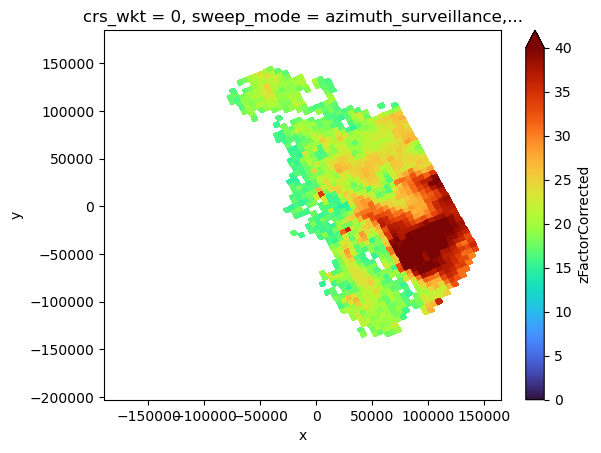

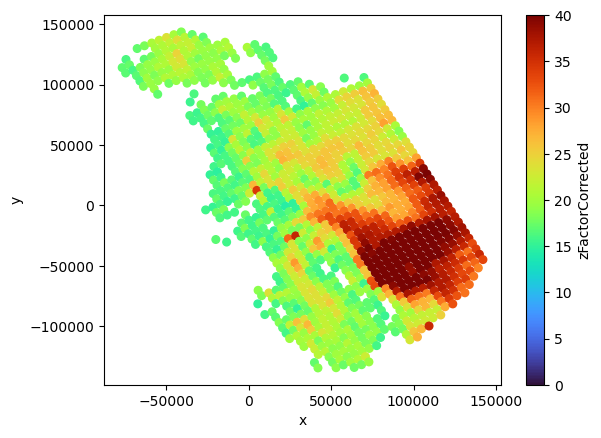

In [48]:
# mean along nbin
sr_match_mean = sr_match.mean(dim="nbin")
sr_match2_mean = sr_match2.mean(dim="nbin")
sr_match_mean.zFactorCorrected.plot(x="x", y="y", cmap="turbo", vmin=0, vmax=40)
plt.figure()
plt.scatter(
    sr_match2_mean.x.values,
    sr_match2_mean.y.values,
    c=sr_match2_mean.zFactorCorrected.values,
    s=30,
    cmap="turbo",
    vmin=0,
    vmax=40,
)
plt.gca().set_xlabel("x")
plt.gca().set_ylabel("y")
plt.colorbar(label="zFactorCorrected")

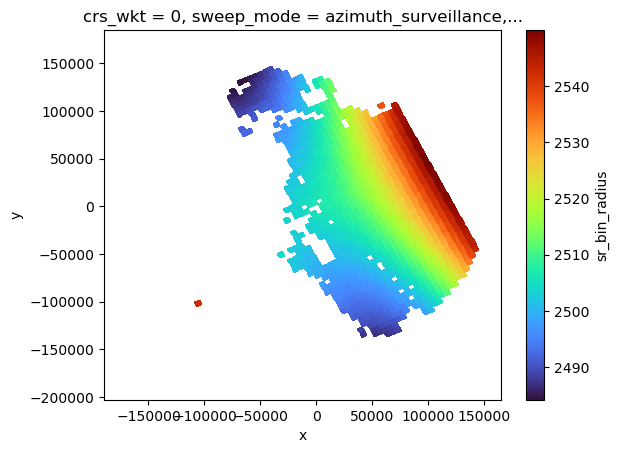

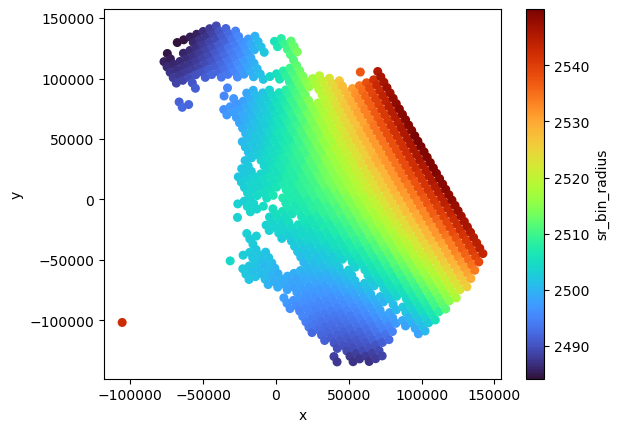

In [49]:
# max along nbin, approximate Rs
sr_match_max = sr_match.max(dim="nbin")
sr_match2_max = sr_match2.max(dim="nbin")
sr_match_max.sr_bin_radius.plot(x="x", y="y", cmap="turbo")
plt.figure()
plt.scatter(
    sr_match2_max.x.values,
    sr_match2_max.y.values,
    c=sr_match2_max.sr_bin_radius.values,
    s=30,
    cmap="turbo",
)
plt.gca().set_xlabel("x")
plt.gca().set_ylabel("y")
plt.colorbar(label="sr_bin_radius")

<xarray.Dataset> Size: 2MB
Dimensions:                      (nscan: 61, nray: 49, XYZ: 3, nNP: 4,
                                  method: 6, foreBack: 2, nearFar: 2, nNode: 5,
                                  nbinSZP: 7, nDSD: 2, nNUBF: 3, LS: 2)
Coordinates:
    Latitude                     (nscan, nray) float32 12kB -27.1 ... -28.47
    Longitude                    (nscan, nray) float32 12kB 151.4 ... 154.9
    date                         (nscan) datetime64[ns] 488B 2014-12-06T09:50...
    x                            (nscan, nray) float64 24kB -1.861e+05 ... 1....
    y                            (nscan, nray) float64 24kB 6.695e+04 ... -8....
    crs_wkt                      int64 8B 0
    sweep_mode                   <U20 80B 'azimuth_surveillance'
    longitude                    float64 8B 153.2
    latitude                     float64 8B -27.72
    altitude                     float64 8B 175.0
Dimensions without coordinates: nscan, nray, XYZ, nNP, method, foreBack,
                                nearFar, nNode, nbinSZP, nDSD, nNUBF, LS
Data variables: (12/105)
    dataQuality                  (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0
    dataWarning                  (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0
    missing                      (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0
    modeStatus                   (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0
    geoError                     (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0
    geoWarning                   (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0
    ...                           ...
    sr_bin_depth                 (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0
    bb_ratio                     (nscan, nray) float64 24kB 0.0 0.0 ... 0.0 0.0
    bb_mask                      (nscan, nray) float64 24kB 0.0 0.0 ... 0.0 0.0
    ref_sr_com                   (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0
    ref_sr_ss                    (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0
    ref_sr_sh                    (nscan, nray) float32 12kB 0.0 0.0 ... 0.0 0.0

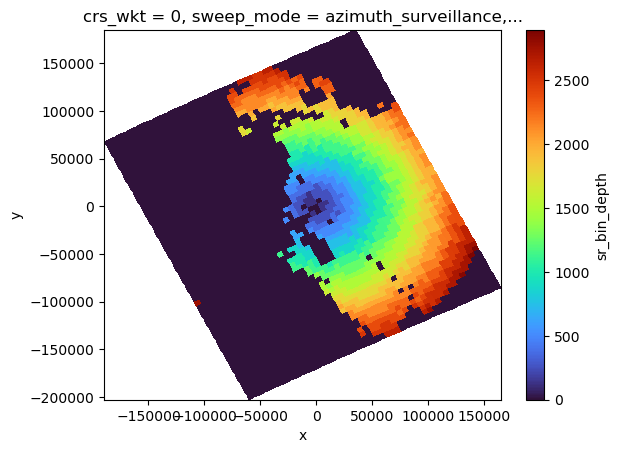

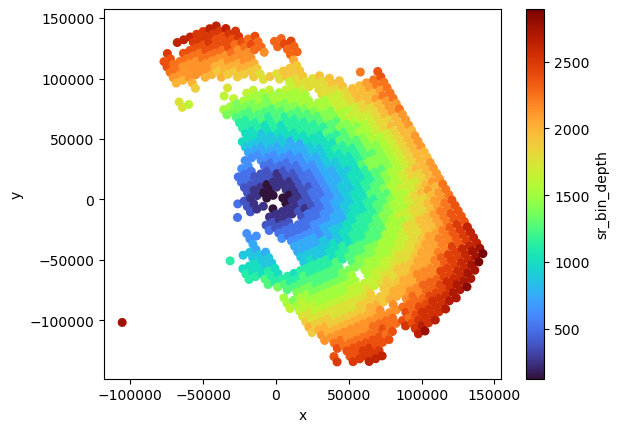

In [50]:
# sum along nbin
# approximate Ds and Vs
sr_match_sum = sr_match.sum(dim="nbin", skipna=True)
sr_match2_sum = sr_match2.sum(dim="nbin", skipna=True)
display(sr_match_sum)
sr_match_sum.sr_bin_depth.plot(x="x", y="y", cmap="turbo")
plt.figure()
plt.scatter(
    sr_match2_sum.x.values,
    sr_match2_sum.y.values,
    c=sr_match2_sum.sr_bin_depth.values,
    s=30,
    cmap="turbo",
)
plt.gca().set_xlabel("x")
plt.gca().set_ylabel("y")
plt.colorbar(label="sr_bin_depth")

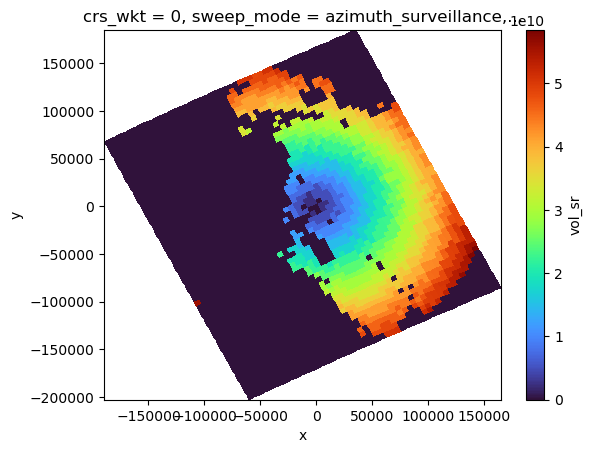

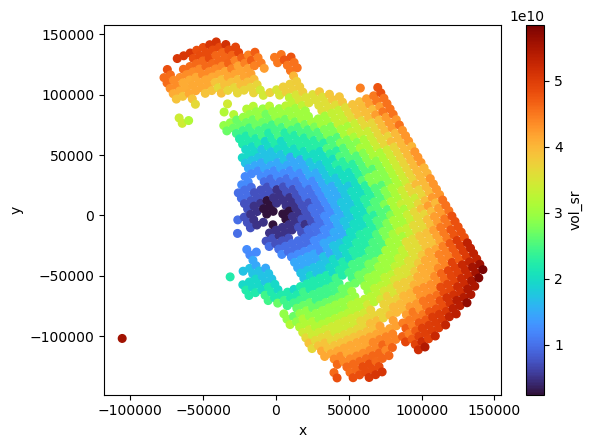

In [51]:
sr_match_sum.vol_sr.plot(x="x", y="y", cmap="turbo")
plt.figure()
plt.scatter(
    sr_match2_sum.x.values,
    sr_match2_sum.y.values,
    c=sr_match2_sum.vol_sr.values,
    s=30,
    cmap="turbo",
)
plt.gca().set_xlabel("x")
plt.gca().set_ylabel("y")
plt.colorbar(label="vol_sr")

# Identify which GR bins actually intersect with the SR footprint

In [52]:
sr_match2_mean

<xarray.Dataset> Size: 862kB
Dimensions:                      (nbeams: 1218, XYZ: 3, nNP: 4, method: 6,
                                  foreBack: 2, nearFar: 2, nNode: 5,
                                  nbinSZP: 7, nDSD: 2, nNUBF: 3, LS: 2)
Coordinates: (12/13)
  * nbeams                       (nbeams) object 10kB MultiIndex
  * nscan                        (nbeams) int64 10kB 0 0 0 0 0 ... 59 60 60 60
  * nray                         (nbeams) int64 10kB 26 27 28 29 ... 36 27 28 29
    Latitude                     (nbeams) float32 5kB -26.55 -26.52 ... -28.88
    Longitude                    (nbeams) float32 5kB 152.6 152.6 ... 154.0
    date                         (nbeams) datetime64[ns] 10kB 2014-12-06T09:5...
    ...                           ...
    y                            (nbeams) float64 10kB 1.298e+05 ... -1.294e+05
    crs_wkt                      int64 8B 0
    sweep_mode                   <U20 80B 'azimuth_surveillance'
    longitude                    float64 8B 153.2
    latitude                     float64 8B -27.72
    altitude                     float64 8B 175.0
Dimensions without coordinates: XYZ, nNP, method, foreBack, nearFar, nNode,
                                nbinSZP, nDSD, nNUBF, LS
Data variables: (12/105)
    dataQuality                  (nbeams) float32 5kB 0.0 0.0 0.0 ... 0.0 0.0
    dataWarning                  (nbeams) float32 5kB 0.0 0.0 0.0 ... 0.0 0.0
    missing                      (nbeams) float32 5kB 0.0 0.0 0.0 ... 0.0 0.0
    modeStatus                   (nbeams) float32 5kB 0.0 0.0 0.0 ... 0.0 0.0
    geoError                     (nbeams) float32 5kB 0.0 0.0 0.0 ... 0.0 0.0
    geoWarning                   (nbeams) float32 5kB 0.0 0.0 0.0 ... 0.0 0.0
    ...                           ...
    sr_bin_depth                 (nbeams) float32 5kB 125.0 125.1 ... 125.3
    bb_ratio                     (nbeams) float64 10kB 0.0 1.858 ... 0.0 2.054
    bb_mask                      (nbeams) float64 10kB 0.0 1.0 1.0 ... 0.0 1.0
    ref_sr_com                   (nbeams) float32 5kB nan 18.38 ... nan 19.8
    ref_sr_ss                    (nbeams) float32 5kB nan 18.38 ... nan 19.8
    ref_sr_sh                    (nbeams) float32 5kB nan 18.81 ... nan 20.03

In [53]:
%%time
## Create Zonal Data Source of matching SR profiles
xyp_sr = np.stack([sr_match2_mean.xp, sr_match2_mean.yp], axis=-1)
zds = wrl.io.VectorSource(xyp_sr, trg_crs=rad)

CPU times: user 19.4 ms, sys: 6.04 ms, total: 25.5 ms
Wall time: 25.1 ms


In [54]:
%%time
## Create SR beam polygons using sr_bin_radius Rs
tmp_trg_lyr = zds.ds.GetLayer()
trg_poly = []
for i, feat in enumerate(tmp_trg_lyr):
    geom = feat.GetGeometryRef().Buffer(sr_match2_max.sr_bin_radius.values[i])
    poly = wrl.georef.ogr_to_numpy(geom)
    trg_poly.append(poly)

CPU times: user 1.4 s, sys: 1.98 ms, total: 1.4 s
Wall time: 1.4 s


In [55]:
gr_poly.shape

(360, 600, 5, 3)

In [56]:
%%time
## Create ZonalDataPoly for GR and SR profiles
print("Create ZonalDataPoly for GR and SR profiles.")
print("This process can take a few seconds... ")

zdp = wrl.zonalstats.ZonalDataPoly(
    gr_poly[..., 0:2].reshape(-1, 5, 2), trg=trg_poly, crs=rad
)

Create ZonalDataPoly for GR and SR profiles.
This process can take a few seconds... 


CPU times: user 8.34 s, sys: 1.62 s, total: 9.96 s
Wall time: 9.97 s


In [57]:
%%time
# dump zonal data
zdp.dump_vector("m3d_zonal_poly_{0}".format(platf))

CPU times: user 888 ms, sys: 785 ms, total: 1.67 s
Wall time: 1.67 s


In [58]:
# %%time
print("loading")
obj3 = wrl.zonalstats.ZonalStatsPoly("m3d_zonal_poly_{0}".format(platf))

loading


In [59]:
## Average GR volume and reflectivity
volgr1 = np.array(
    [
        np.sum(vol_gr.values.ravel()[obj3.ix[i]])
        for i in np.arange(len(obj3.ix))[~obj3.check_empty()]
    ]
)

# SR Reflectivity matched

In [60]:
# converted for stratiform
ref_sr2gr_m = sr_match2.ref_sr_com.copy()
ref_sr2gr_m = wrl.trafo.idecibel(ref_sr2gr_m)
ref_sr2gr_m = ref_sr2gr_m.mean(dim="nbin", skipna=True)
ref_sr2gr_m = wrl.trafo.decibel(ref_sr2gr_m)
display(ref_sr2gr_m)

<xarray.DataArray 'ref_sr_com' (nbeams: 1218)> Size: 5kB
array([      nan, 19.49539 , 23.312458, ..., 18.637308,       nan,
       21.192059], shape=(1218,), dtype=float32)
Coordinates: (12/13)
  * nbeams      (nbeams) object 10kB MultiIndex
  * nscan       (nbeams) int64 10kB 0 0 0 0 0 0 0 1 ... 59 59 59 59 59 60 60 60
  * nray        (nbeams) int64 10kB 26 27 28 29 30 31 32 ... 29 35 36 27 28 29
    Latitude    (nbeams) float32 5kB -26.55 -26.52 -26.5 ... -28.93 -28.9 -28.88
    Longitude   (nbeams) float32 5kB 152.6 152.6 152.6 ... 153.9 153.9 154.0
    date        (nbeams) datetime64[ns] 10kB 2014-12-06T09:50:30.000500 ... 2...
    ...          ...
    y           (nbeams) float64 10kB 1.298e+05 1.32e+05 ... -1.294e+05
    crs_wkt     int64 8B 0
    sweep_mode  <U20 80B 'azimuth_surveillance'
    longitude   float64 8B 153.2
    latitude    float64 8B -27.72
    altitude    float64 8B 175.0

In [61]:
ref_sr_m = wrl.trafo.idecibel(sr_match2.zFactorCorrected)
ref_sr_m = ref_sr_m.mean(dim="nbin", skipna=True)
ref_sr_m = wrl.trafo.decibel(ref_sr_m)
display(ref_sr_m)

<xarray.DataArray 'zFactorCorrected' (nbeams: 1218)> Size: 5kB
array([17.571447, 18.82063 , 22.596802, ..., 18.23964 , 18.275768,
       20.90188 ], shape=(1218,), dtype=float32)
Coordinates: (12/13)
  * nbeams      (nbeams) object 10kB MultiIndex
  * nscan       (nbeams) int64 10kB 0 0 0 0 0 0 0 1 ... 59 59 59 59 59 60 60 60
  * nray        (nbeams) int64 10kB 26 27 28 29 30 31 32 ... 29 35 36 27 28 29
    Latitude    (nbeams) float32 5kB -26.55 -26.52 -26.5 ... -28.93 -28.9 -28.88
    Longitude   (nbeams) float32 5kB 152.6 152.6 152.6 ... 153.9 153.9 154.0
    date        (nbeams) datetime64[ns] 10kB 2014-12-06T09:50:30.000500 ... 2...
    ...          ...
    y           (nbeams) float64 10kB 1.298e+05 1.32e+05 ... -1.294e+05
    crs_wkt     int64 8B 0
    sweep_mode  <U20 80B 'azimuth_surveillance'
    longitude   float64 8B 153.2
    latitude    float64 8B -27.72
    altitude    float64 8B 175.0

In [62]:
def plot_matched_refl(sr_data, gr_data, xyz):
    """
    Plotting unmatched SR and GR Reflectivity

    # Input:
    # ------
    gr_data ::: graund radar sweep data
    sr_data ::: satellite data

    # Output:
    # ------
    Plot of SR Refl. and GR Refl.

    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(
        xyz[..., 0],
        xyz[..., 1],
        c=sr_data.data,
        s=10,
        cmap="turbo",
        vmin=0,
        vmax=40,
    )
    cbar = plt.colorbar(ticks=np.arange(0, 42, 2))
    cbar.set_label("SR Reflectivity (dBz)", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    plt.xlabel("Longitude (°)", fontsize=12)
    plt.ylabel("Latitude (°)", fontsize=12)
    a = plt.xticks(fontsize=12)
    a = plt.yticks(fontsize=12)
    plt.title("Satellite Radar", fontsize=12, loc="left")

    plt.grid(lw=0.25, color="grey")

    plt.subplot(1, 2, 2)
    plt.scatter(
        xyz[..., 0], xyz[..., 1], c=gr_data, s=10, cmap="turbo", vmin=0, vmax=40
    )
    cbar = plt.colorbar(ticks=np.arange(0, 42, 2))
    cbar.set_label("GR Reflectivity (dBz)", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    plt.xlabel("x (km)", fontsize=12)
    plt.ylabel("y (km)", fontsize=12)
    a = plt.xticks(fontsize=12)
    a = plt.yticks(fontsize=12)
    plt.title("Ground Radar", fontsize=12, loc="left")
    plt.grid(lw=0.25, color="grey")
    plt.tight_layout()

# Ground Radar Reflectivity matched

In [63]:
mean = obj3.mean(wrl.trafo.idecibel(swp.DBZH).values.ravel())
obj3.zdata.trg.geo["mean"] = wrl.trafo.decibel(mean)
ref_gr_m = obj3.zdata.trg.geo["mean"]

In [64]:
mean = obj3.mean(wrl.trafo.idecibel(ref_gr2sr).values.ravel())
obj3.zdata.trg.geo["mean"] = wrl.trafo.decibel(mean)
ref_gr2sr_m = obj3.zdata.trg.geo["mean"]

In [65]:
# todo: title fig.suptitle("GR vs SR (to_gr)") etc

Text(0.5, 0.98, 'GR vs SR (to_gr)')

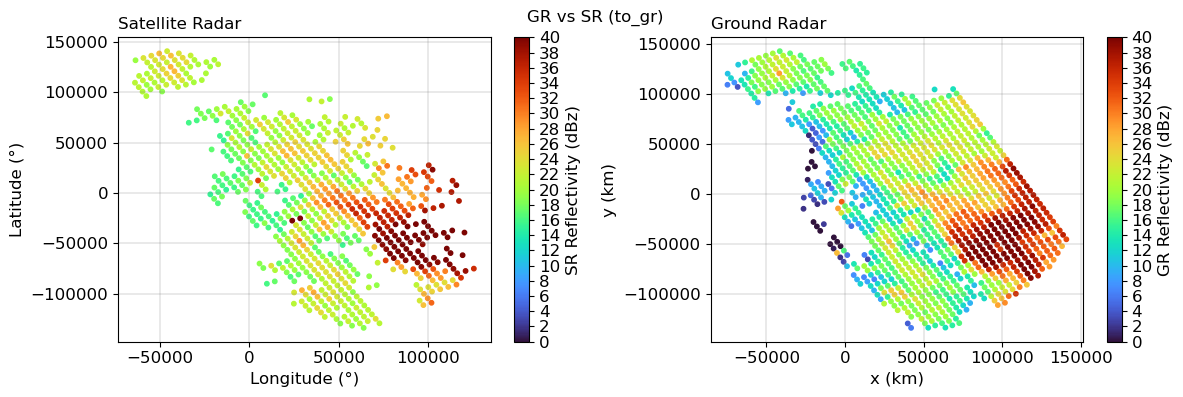

In [66]:
plot_matched_refl(ref_sr2gr_m, ref_gr_m, xyp_sr)
plt.suptitle("GR vs SR (to_gr)")

Text(0.5, 0.98, 'GR (to_sr) vs SR')

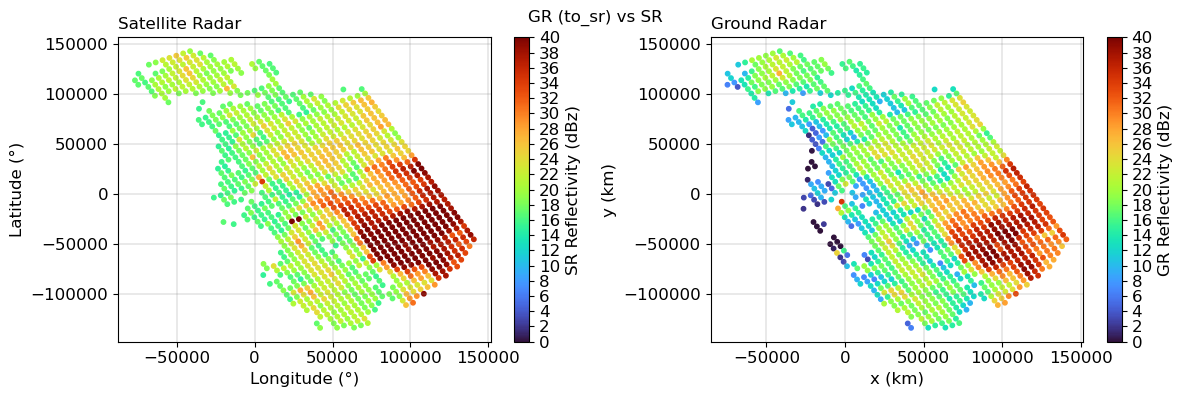

In [67]:
plot_matched_refl(ref_sr_m, ref_gr2sr_m, xyp_sr)
plt.suptitle("GR (to_sr) vs SR")

# Diagnostic Plots

In [68]:
volcol = sr_match2_sum.vol_sr

Text(0.5, 0.98, 'GR vs SR (to_gr)')

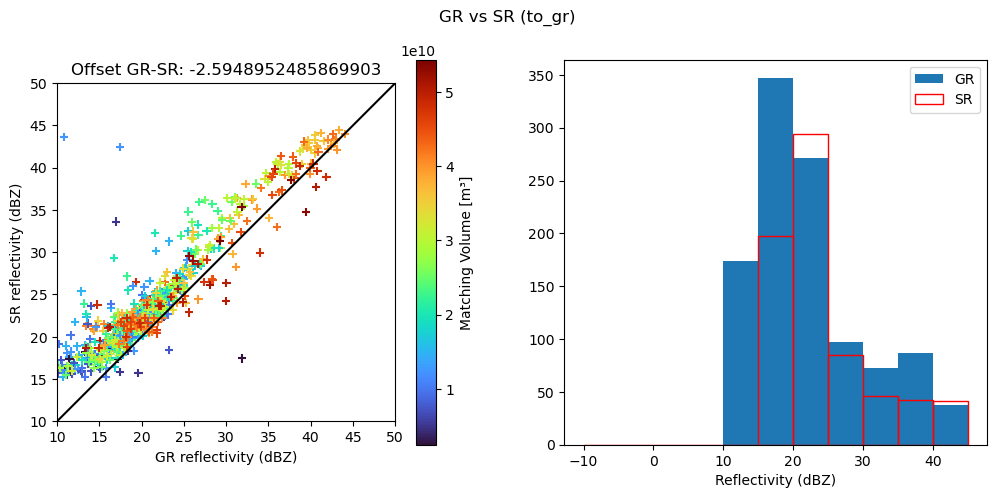

In [69]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, aspect="equal")
plt.scatter(
    ref_gr_m.values, ref_sr2gr_m.values.ravel(), marker="+", c=volcol, cmap="turbo"
)
plt.colorbar(label="Matching Volume [m³]")
plt.plot([0, 60], [0, 60], linestyle="solid", color="black")
plt.xlim(10, 50)
plt.ylim(10, 50)
plt.xlabel("GR reflectivity (dBZ)")
plt.ylabel("SR reflectivity (dBZ)")
plt.title(f"Offset GR-SR: {np.nanmedian(ref_gr_m.values - ref_sr2gr_m.values.ravel())}")
ax = fig.add_subplot(122)
plt.hist(
    ref_gr_m[ref_gr_m > 10], bins=np.arange(-10, 50, 5), edgecolor="None", label="GR"
)
plt.hist(
    ref_sr2gr_m[ref_sr2gr_m > -10],
    bins=np.arange(-10, 50, 5),
    edgecolor="red",
    facecolor="None",
    label="SR",
)
plt.xlabel("Reflectivity (dBZ)")
plt.legend()
fig.suptitle("GR vs SR (to_gr)")

Text(0.5, 0.98, 'GR (to_sr) vs SR')

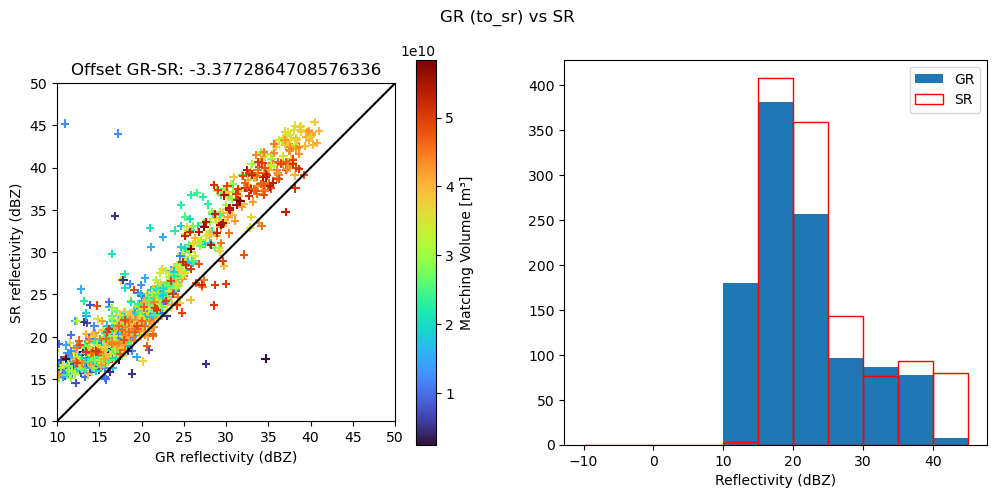

In [70]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, aspect="equal")
plt.scatter(ref_gr2sr_m, ref_sr_m, marker="+", c=volcol, cmap="turbo")
plt.colorbar(label="Matching Volume [m³]")
plt.plot([0, 60], [0, 60], linestyle="solid", color="black")
plt.xlim(10, 50)
plt.ylim(10, 50)
plt.xlabel("GR reflectivity (dBZ)")
plt.ylabel("SR reflectivity (dBZ)")
plt.title(f"Offset GR-SR: {np.nanmedian(ref_gr2sr_m.values - ref_sr_m.values.ravel())}")
ax = fig.add_subplot(122)
plt.hist(
    ref_gr2sr_m[ref_gr2sr_m > 10],
    bins=np.arange(-10, 50, 5),
    edgecolor="None",
    label="GR",
)
plt.hist(
    ref_sr_m[ref_sr_m > -10],
    bins=np.arange(-10, 50, 5),
    edgecolor="red",
    facecolor="None",
    label="SR",
)
plt.xlabel("Reflectivity (dBZ)")
plt.legend()
fig.suptitle("GR (to_sr) vs SR")